# DSO 522: Applied Time Series Analysis for Forecasting

## Week 11: Dynamic regression models

### Fall 2024

#### Instructor: Dr. Matteo Sesia

<p align="center">
  <img src="img/marshall.png" alt="Marshall School of Business" width="600"/>
</p>

<link rel="stylesheet" type="text/css" href="custom.css">

# Interactive slides

These lecture slides are made using an interactive [Jupyter](https://jupyter.org/) notebook, powered by the [RISE](https://rise.readthedocs.io/en/latest/) extension.

In the lectures, we will run `R` code in Jupyter, using the `fpp3` package (which you should have already installed).

In [1]:
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

library(repr)
options(repr.matrix.max.rows=4)
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)

## Review

Previously:
- ARIMA and Exponential Smoothing models allow for the inclusion of information from past observations of a series, but not for the inclusion of other information that may also be relevant. 

- Linear regression models predict $y_t$ using a linear combination of $k$ predictor variables $x_{1,t},\dots,x_{k,t}$ as: $y_t = \beta_0 + \beta_1 x_{1,t} + \dots + \beta_k x_{k,t} + \varepsilon_t,$ where $\varepsilon_t$ is usually assumed to be an uncorrelated error term (i.e., it is white noise).

In this chapter, we will allow the errors from a regression to contain autocorrelation.

## Dynamic regression models

A linear regression models that allows the errors $(\eta_t)$ to be autocorrelated.

For example, if the errors follow an ARIMA(1,1,1) model:
\begin{align*}
  y_t &= \beta_0 + \beta_1 x_{1,t} + \dots + \beta_k x_{k,t} + \eta_t,\\
      & (1-\phi_1B)(1-B)\eta_t = (1+\theta_1B)\varepsilon_t,
\end{align*}
where $\varepsilon_t$ is a white noise series.


## Estimation

When we estimate the parameters from the model, we need to minimise the sum of squared $\varepsilon_t$ values. 
If we minimise the sum of squared $\eta_t$ values instead, we are ignoring the autocorrelations.

\begin{align*}
  y_t &= \beta_0 + \beta_1 x_{1,t} + \dots + \beta_k x_{k,t} + \eta_t,\\
      & (1-\phi_1B)(1-B)\eta_t = (1+\theta_1B)\varepsilon_t,
\end{align*}

Important: when estimating a regression with ARMA errors, we first have to check that $y_t$ and all of the predictors $(x_{1,t},\ldots,x_{k,t})$ appear to be stationary. 


## Differencing

We therefore first difference the non-stationary variables in the model.

It is often desirable to maintain the form of the relationship between $y_t$ and the predictors, and consequently it is common to difference all of the variables if any of them need differencing.

The resulting model is then called a “model in differences”.

\begin{align*}
  y'_t &= \beta_1 x'_{1,t} + \dots + \beta_k x'_{k,t} + \eta'_t,\\
\end{align*}


## Regression model in differences with ARMA errors

A regression model with ARIMA errors is equivalent to a regression model in differences with ARMA errors (ARMA = ARIMA without differencing). 

For example, if the above regression model with ARIMA(1,1,1) errors is differenced we obtain the model 
\begin{align*}
  y'_t &= \beta_1 x'_{1,t} + \dots + \beta_k x'_{k,t} + \eta'_t,\\
       & (1-\phi_1B)\eta'_t = (1+\theta_1B)\varepsilon_t,
\end{align*}
which is a regression model in differences with ARMA errors.

## Regression with ARIMA errors using `fable`

The function `ARIMA()` will fit a regression model with ARIMA errors if *exogenous* regressors are included in the formula. 

The `pdq()` special specifies the order of the ARIMA error model.

If differencing is specified, then the differencing is applied to all variables in the regression model before the model is estimated. 

For example
```ARIMA(y ~ x + pdq(1,1,0))``` will fit the model $y_t' = \beta_1 x'_t + \eta'_t$ where $\eta'_t = \phi_1 \eta'_{t-1} + \varepsilon_t$ is an AR(1) error.

This is equivalent to the model $y_t = \beta_0 + \beta_1 x_t + \eta_t,$ where $\eta_t$ is an ARIMA(1,1,0) error.

## Regression with ARIMA errors using `fable`

The `ARIMA()` function can also be used to select the best ARIMA model for the errors. This is done by not specifying the `pdq()` special. 

Example: 
```ARIMA(y ~ x)```.

## Example: US Personal Consumption and Income

The `us_change` dataset contains quarterly changes in personal consumption expenditure and personal disposable income from 1970 to 2019 Q2, along with other variables.

In [2]:
us_change

Quarter,Consumption,Income,Production,Savings,Unemployment
<qtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1970 Q1,0.6185664,1.044801,-2.4524855,5.299014,0.9
1970 Q2,0.4519840,1.225647,-0.5514595,7.789894,0.5
⋮,⋮,⋮,⋮,⋮,⋮
2019 Q1,0.2828855,1.1007530,-0.4882059,9.760287,-0.1
2019 Q2,1.1135167,0.5933995,-0.5399494,-4.264616,-0.1


## Example: US Personal Consumption and Income

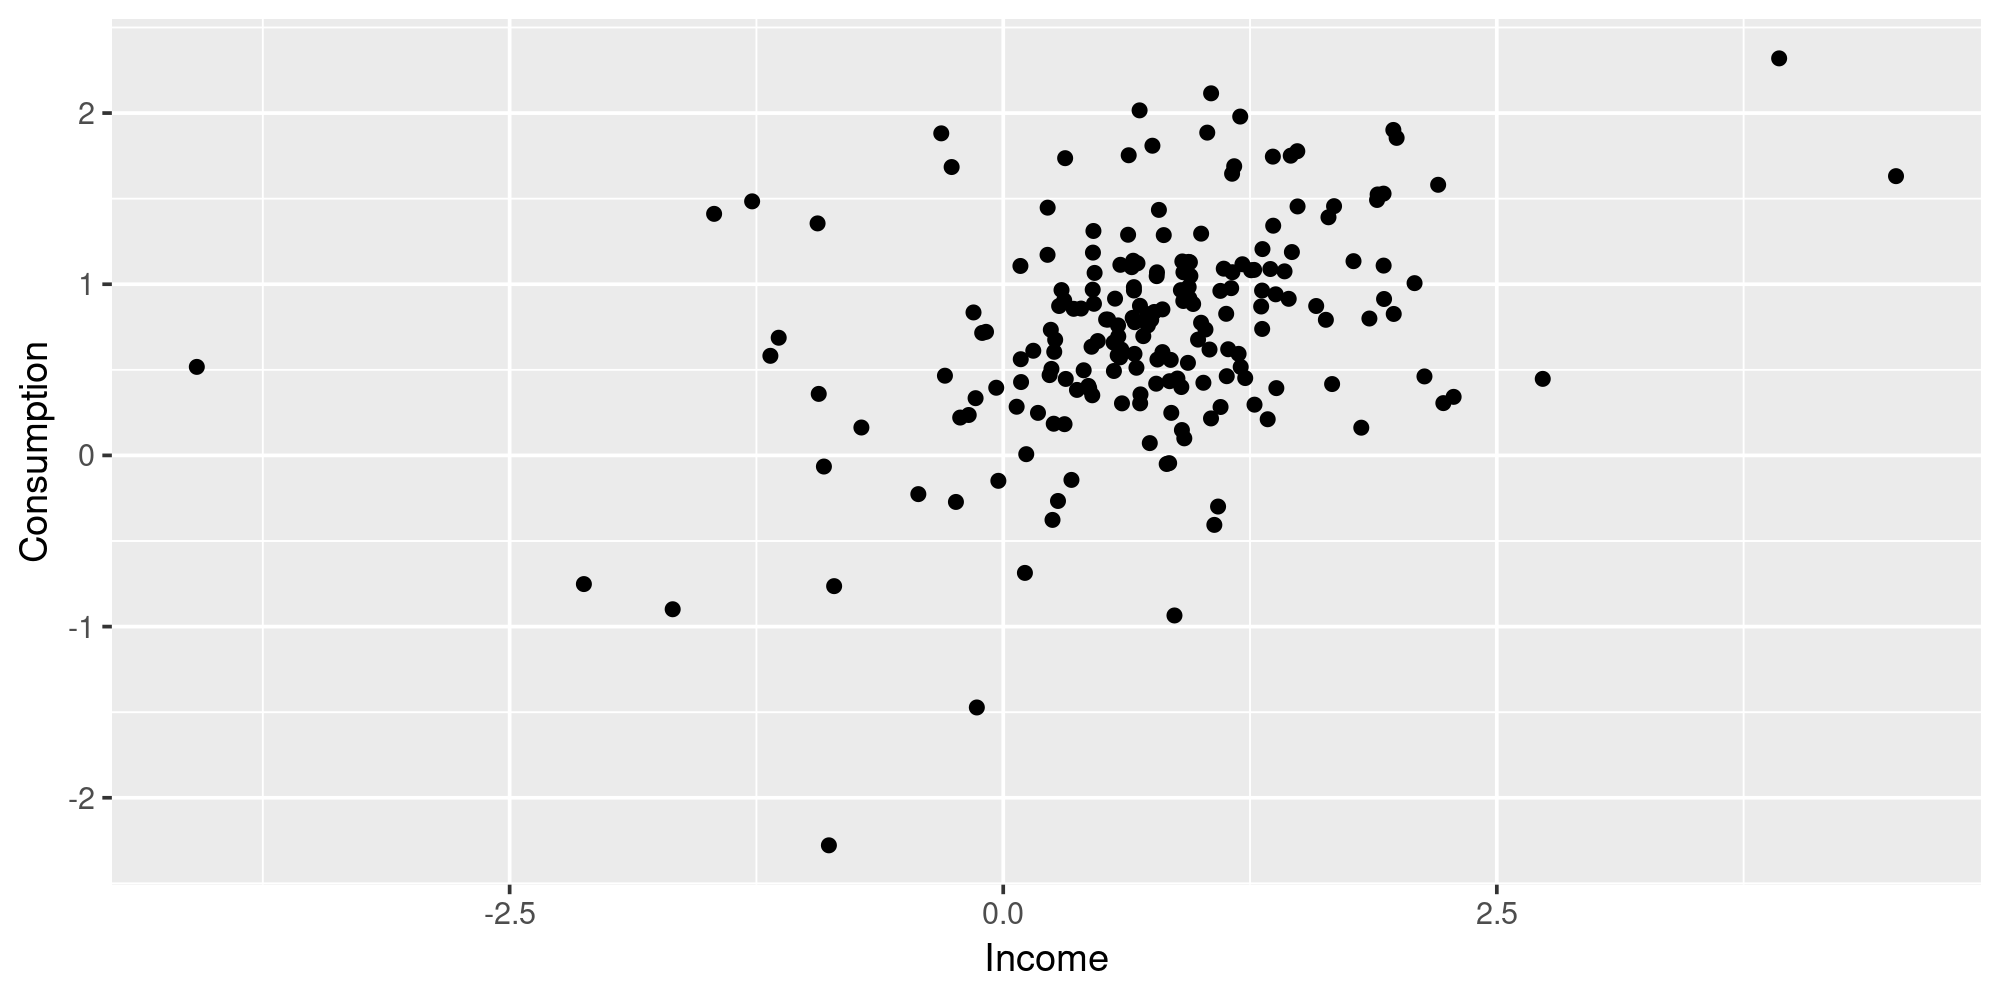

In [3]:
us_change |>
    ggplot(aes(x=Income, y=Consumption)) +
    geom_point()

## Example: US Personal Consumption and Income

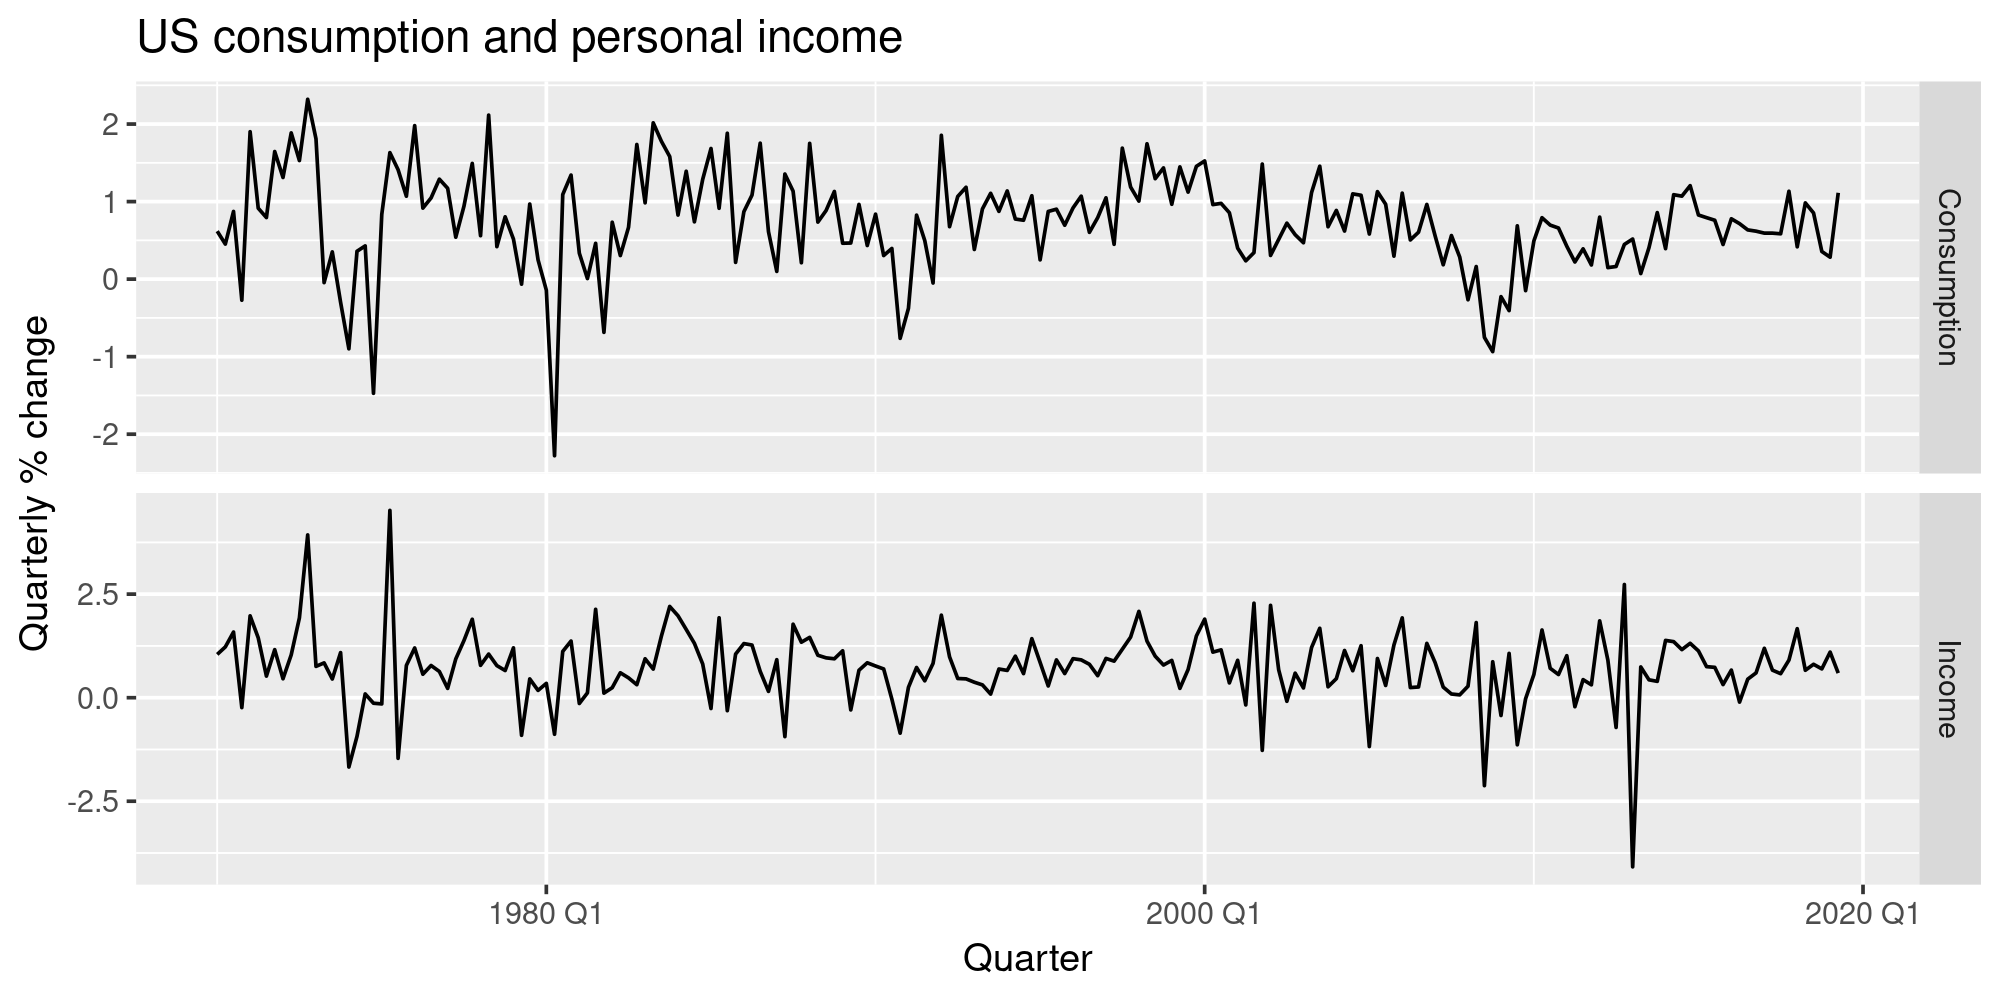

In [4]:
us_change |>
  pivot_longer(c(Consumption, Income), names_to = "var", values_to = "value") |>
  ggplot(aes(x = Quarter, y = value)) +
  geom_line() +
  facet_grid(vars(var), scales = "free_y") +
  labs(title = "US consumption and personal income", y = "Quarterly % change")

## Example: US Personal Consumption and Income

The data are clearly already stationary (as we are considering percentage changes rather than raw expenditure and income), so there is no need for any differencing. 

In [5]:
fit <- us_change |>
  model(ARIMA(Consumption ~ Income))
report(fit)

Series: Consumption 
Model: LM w/ ARIMA(1,0,2) errors 

Coefficients:
         ar1      ma1     ma2  Income  intercept
      0.7070  -0.6172  0.2066  0.1976     0.5949
s.e.  0.1068   0.1218  0.0741  0.0462     0.0850

sigma^2 estimated as 0.3113:  log likelihood=-163.04
AIC=338.07   AICc=338.51   BIC=357.8


 The fitted model is 
\begin{align*}
  y_t &= 0.595 +
         0.198 x_t + \eta_t, \\
  \eta_t &= 0.707 \eta_{t-1} + \varepsilon_t
        -0.617 \varepsilon_{t-1} +
        0.207 \varepsilon_{t-2},\\
  \varepsilon_t &\sim \text{N}(0,0.311).
\end{align*}

## Example: US Personal Consumption and Income

We can recover estimates of both the $\eta_t$ and $\varepsilon_t$ series using the `residuals()` function.

In [6]:
residuals(fit)

.model,Quarter,.resid
<chr>,<qtr>,<dbl>
ARIMA(Consumption ~ Income),1970 Q1,-0.1702101
ARIMA(Consumption ~ Income),1970 Q2,-0.3324590
⋮,⋮,⋮
ARIMA(Consumption ~ Income),2019 Q1,-0.5407430
ARIMA(Consumption ~ Income),2019 Q2,0.5238125


## Example: US Personal Consumption and Income

Plotting the residual series.

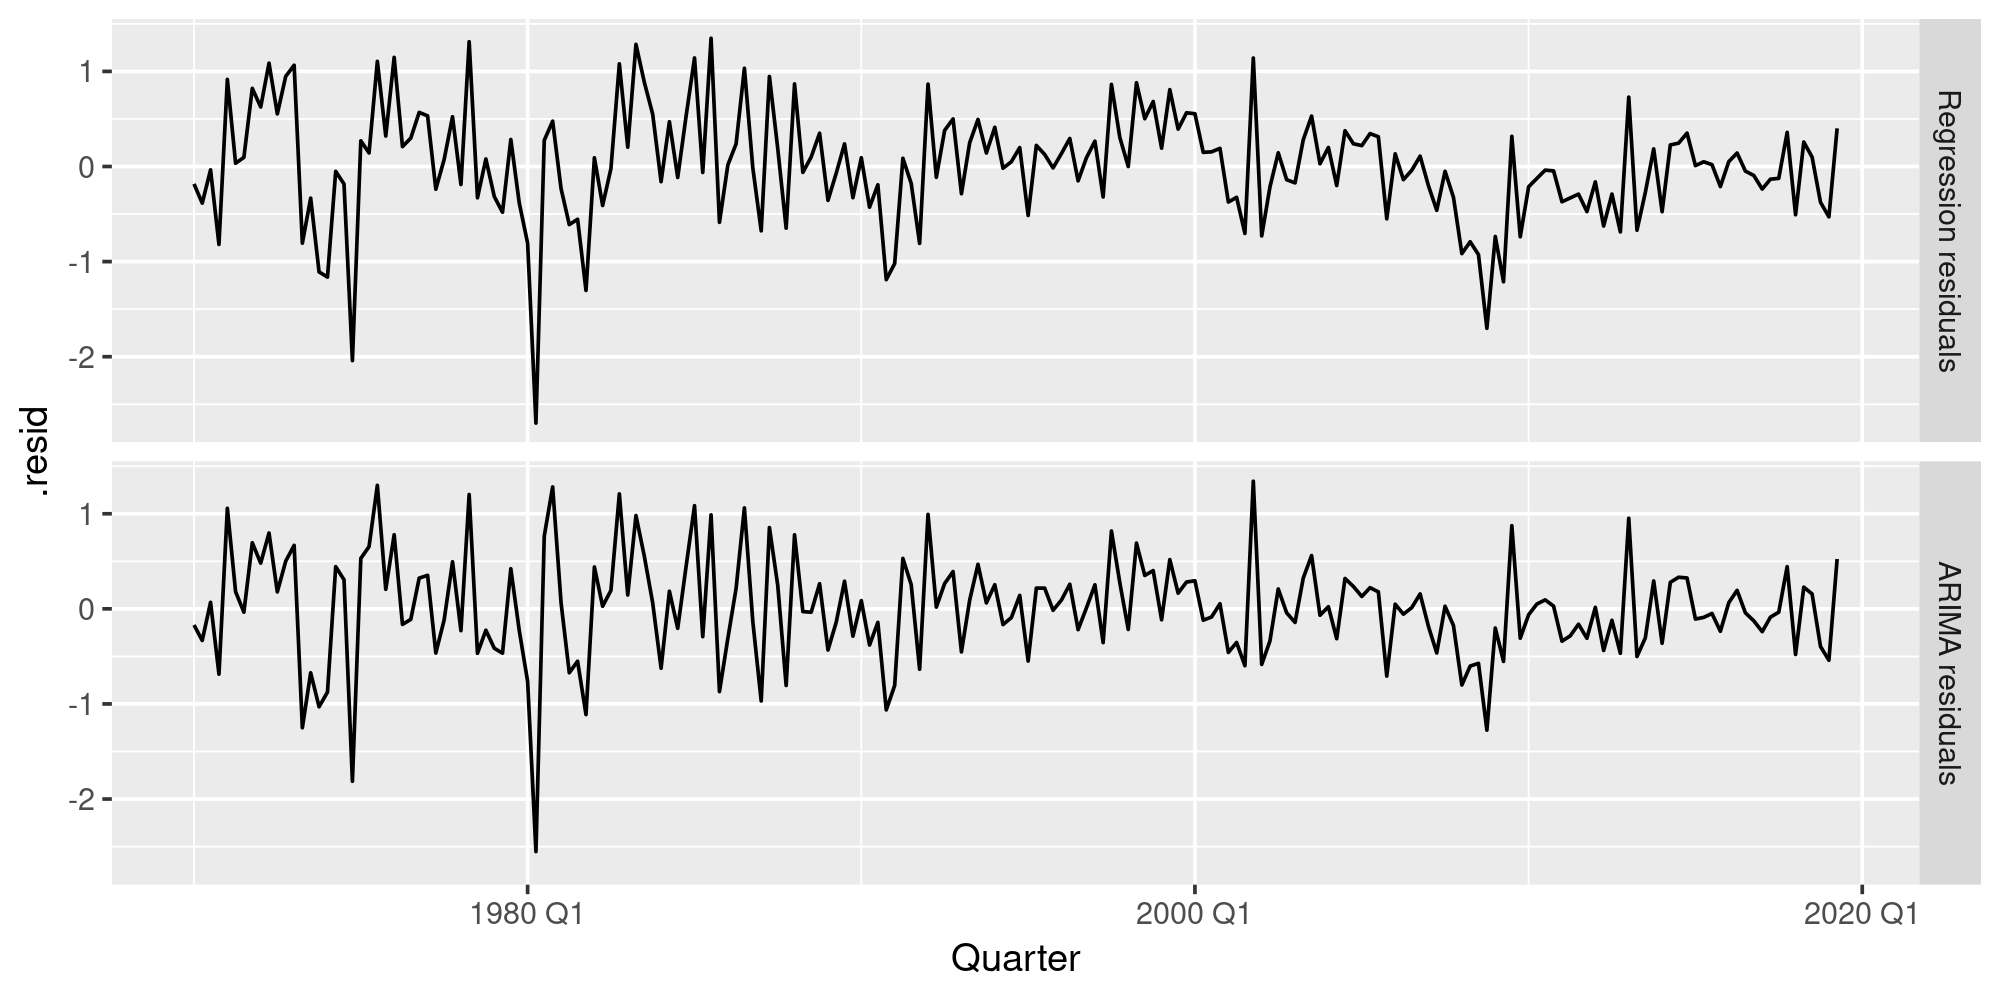

In [7]:
bind_rows(
    `Regression residuals` = as_tibble(residuals(fit, type = "regression")),
    `ARIMA residuals` = as_tibble(residuals(fit, type = "innovation")),
    .id = "type" ) |>
  mutate(type = factor(type, levels=c("Regression residuals", "ARIMA residuals"))) |>
  ggplot(aes(x = Quarter, y = .resid)) +
  geom_line() +
  facet_grid(vars(type))

## Example: US Personal Consumption and Income

It is the ARIMA estimated errors (the innovation residuals) that should resemble a white noise series.

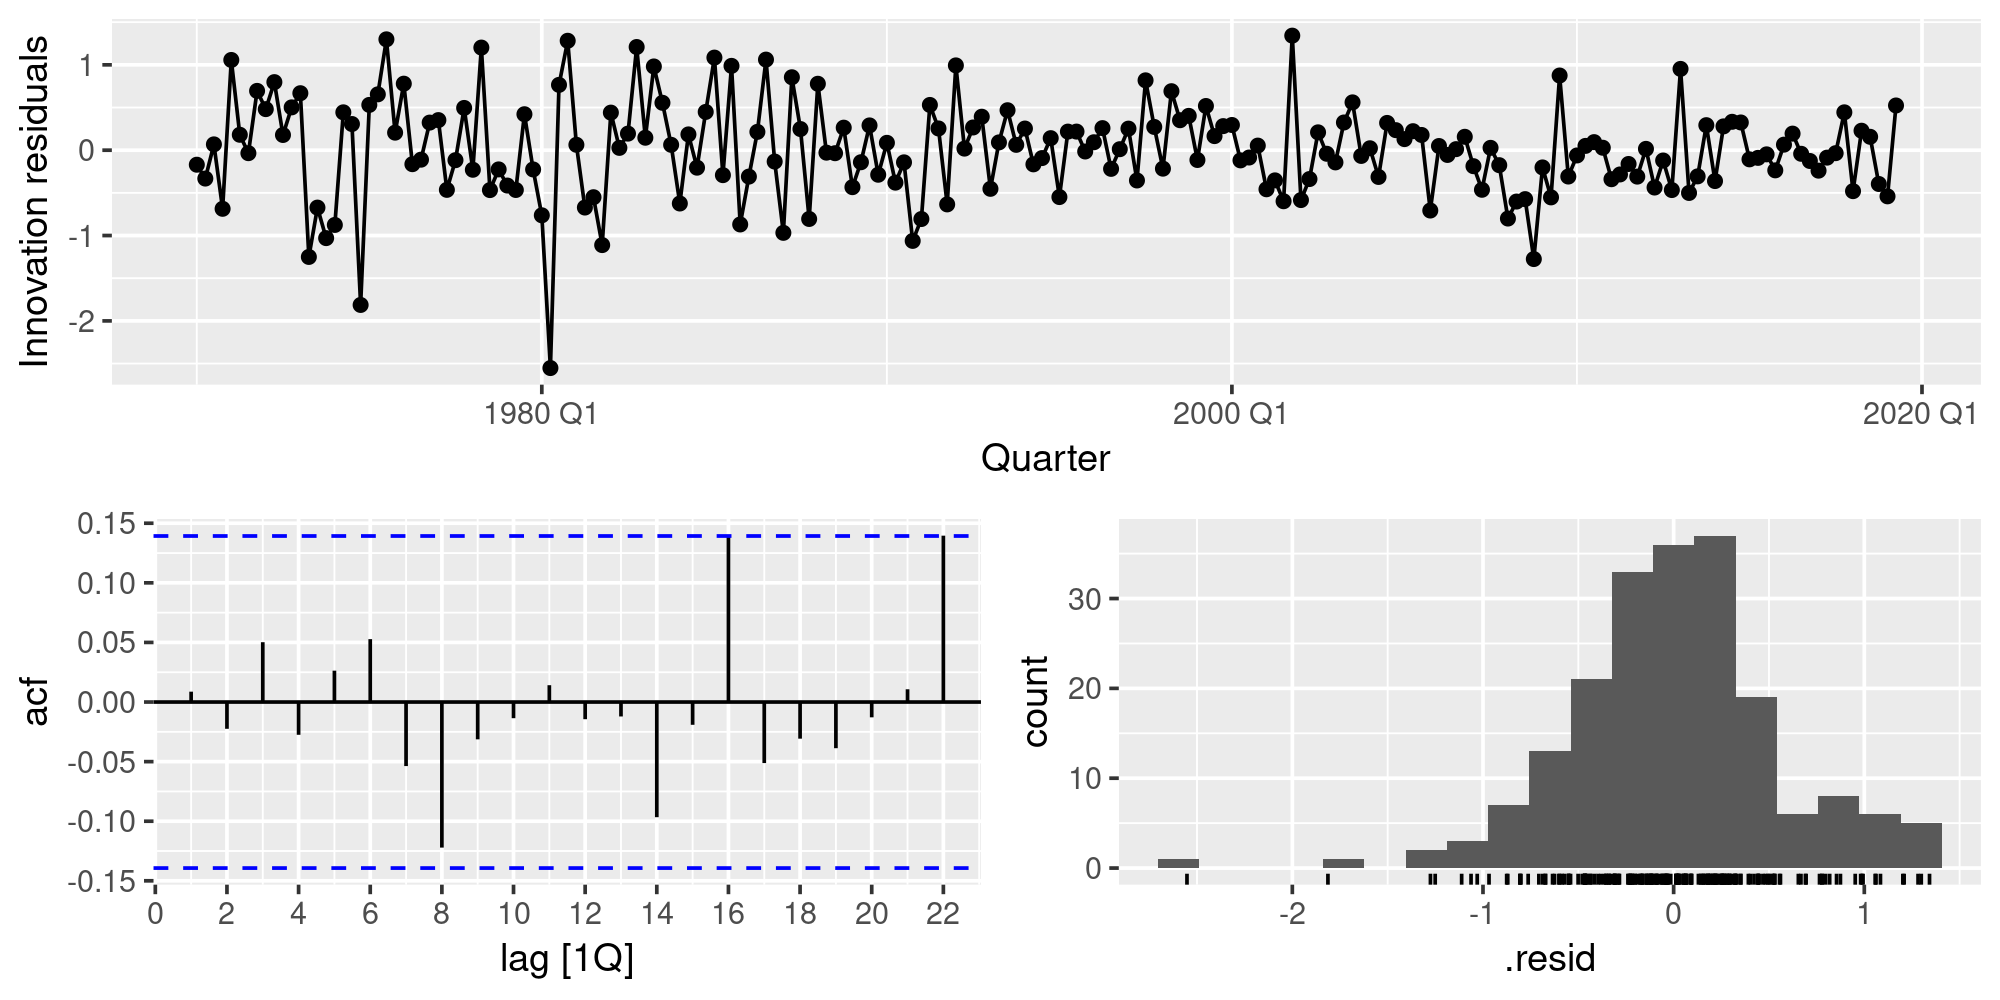

In [8]:
fit |> gg_tsresiduals()

## Forecasting

To forecast using a regression model with ARIMA errors, we need to forecast the regression part of the model and the ARIMA part of the model, and combine the results. 

As with ordinary regression models, in order to obtain forecasts we first need to forecast the predictors. 

If the predictors are themselves unknown, we must either model them separately, or use assumed future values for each predictor.

## Example: US Personal Consumption and Income

We will calculate forecasts for the next eight quarters **assuming** that the future percentage changes in personal disposable income will be equal to the mean percentage change from the last forty years.

In [9]:
us_change_future <- new_data(us_change, 8) |>
  mutate(Income = mean(us_change$Income))
#us_change_future

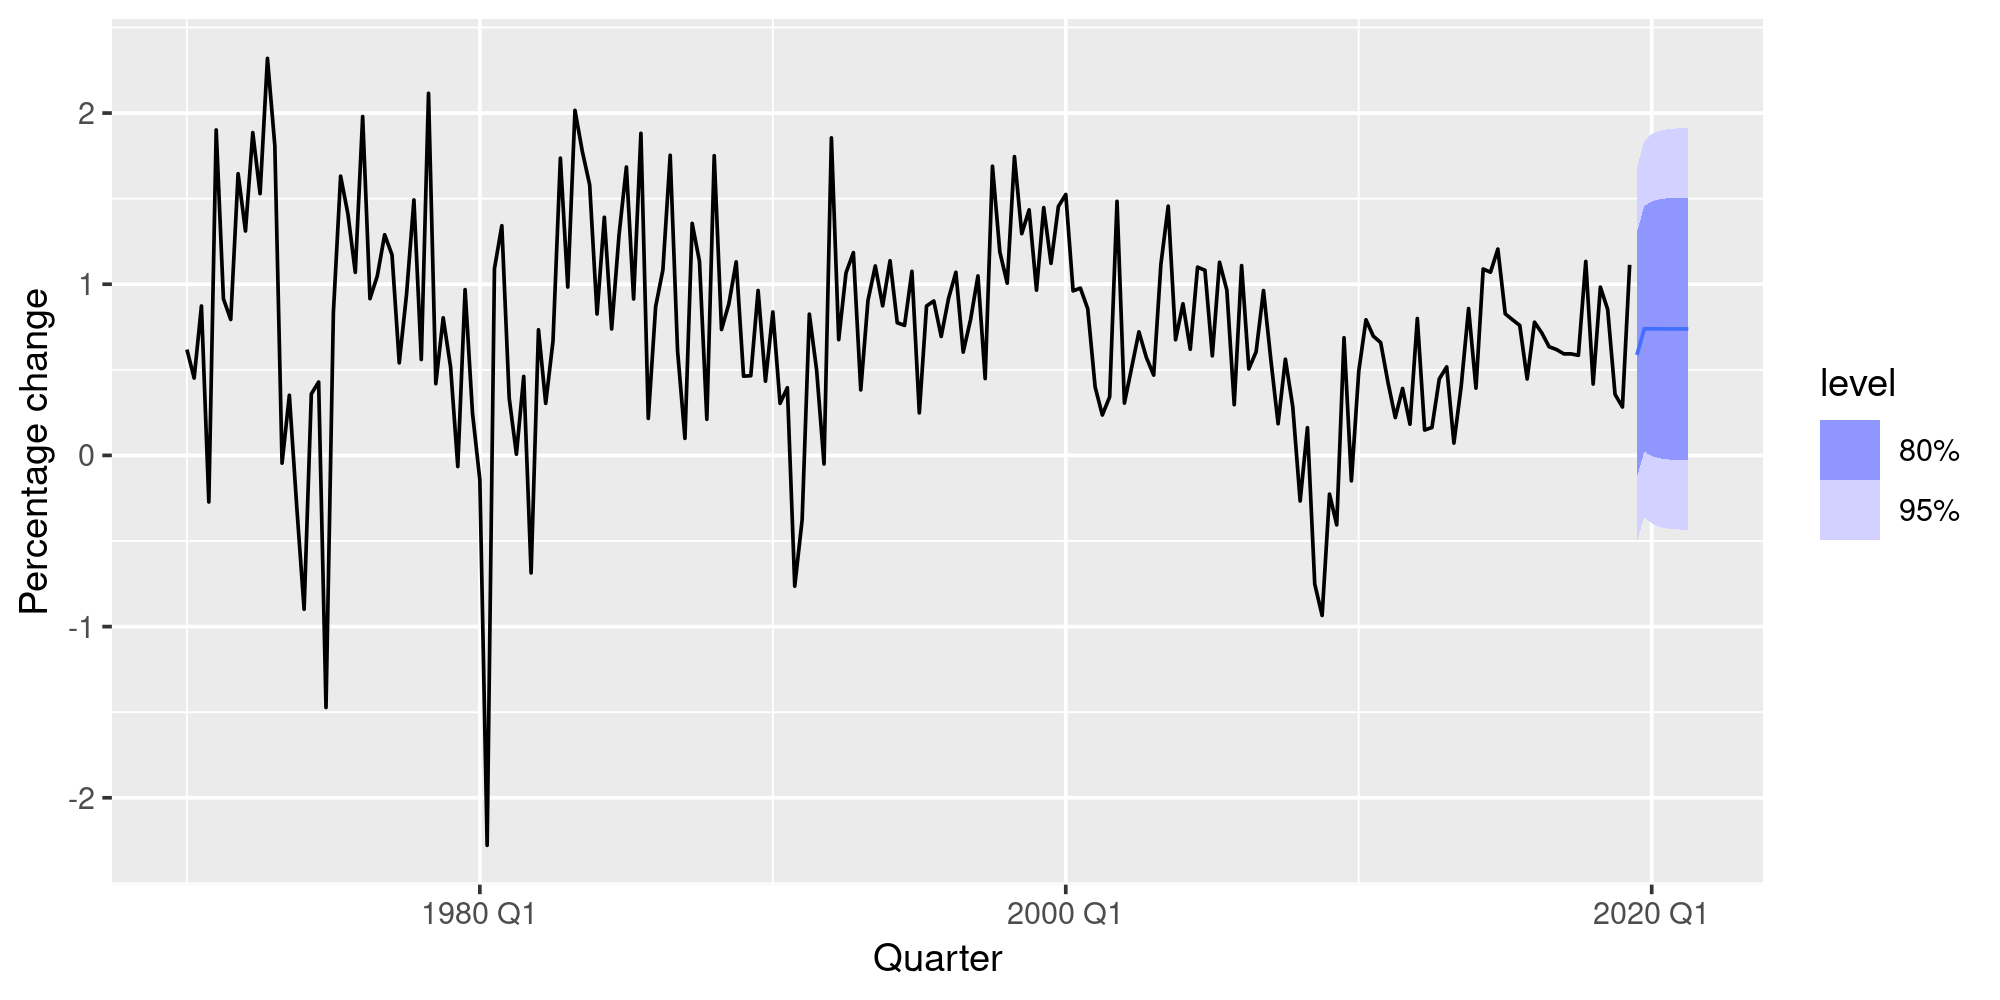

In [10]:
forecast(fit, new_data = us_change_future) |>
  autoplot(us_change) +
  labs(y = "Percentage change")

## Example: US Personal Consumption and Income

The prediction intervals for this model are narrower than if we had fitted an ARIMA model without covariates, because we are now able to explain some of the variation in the data using the income predictor

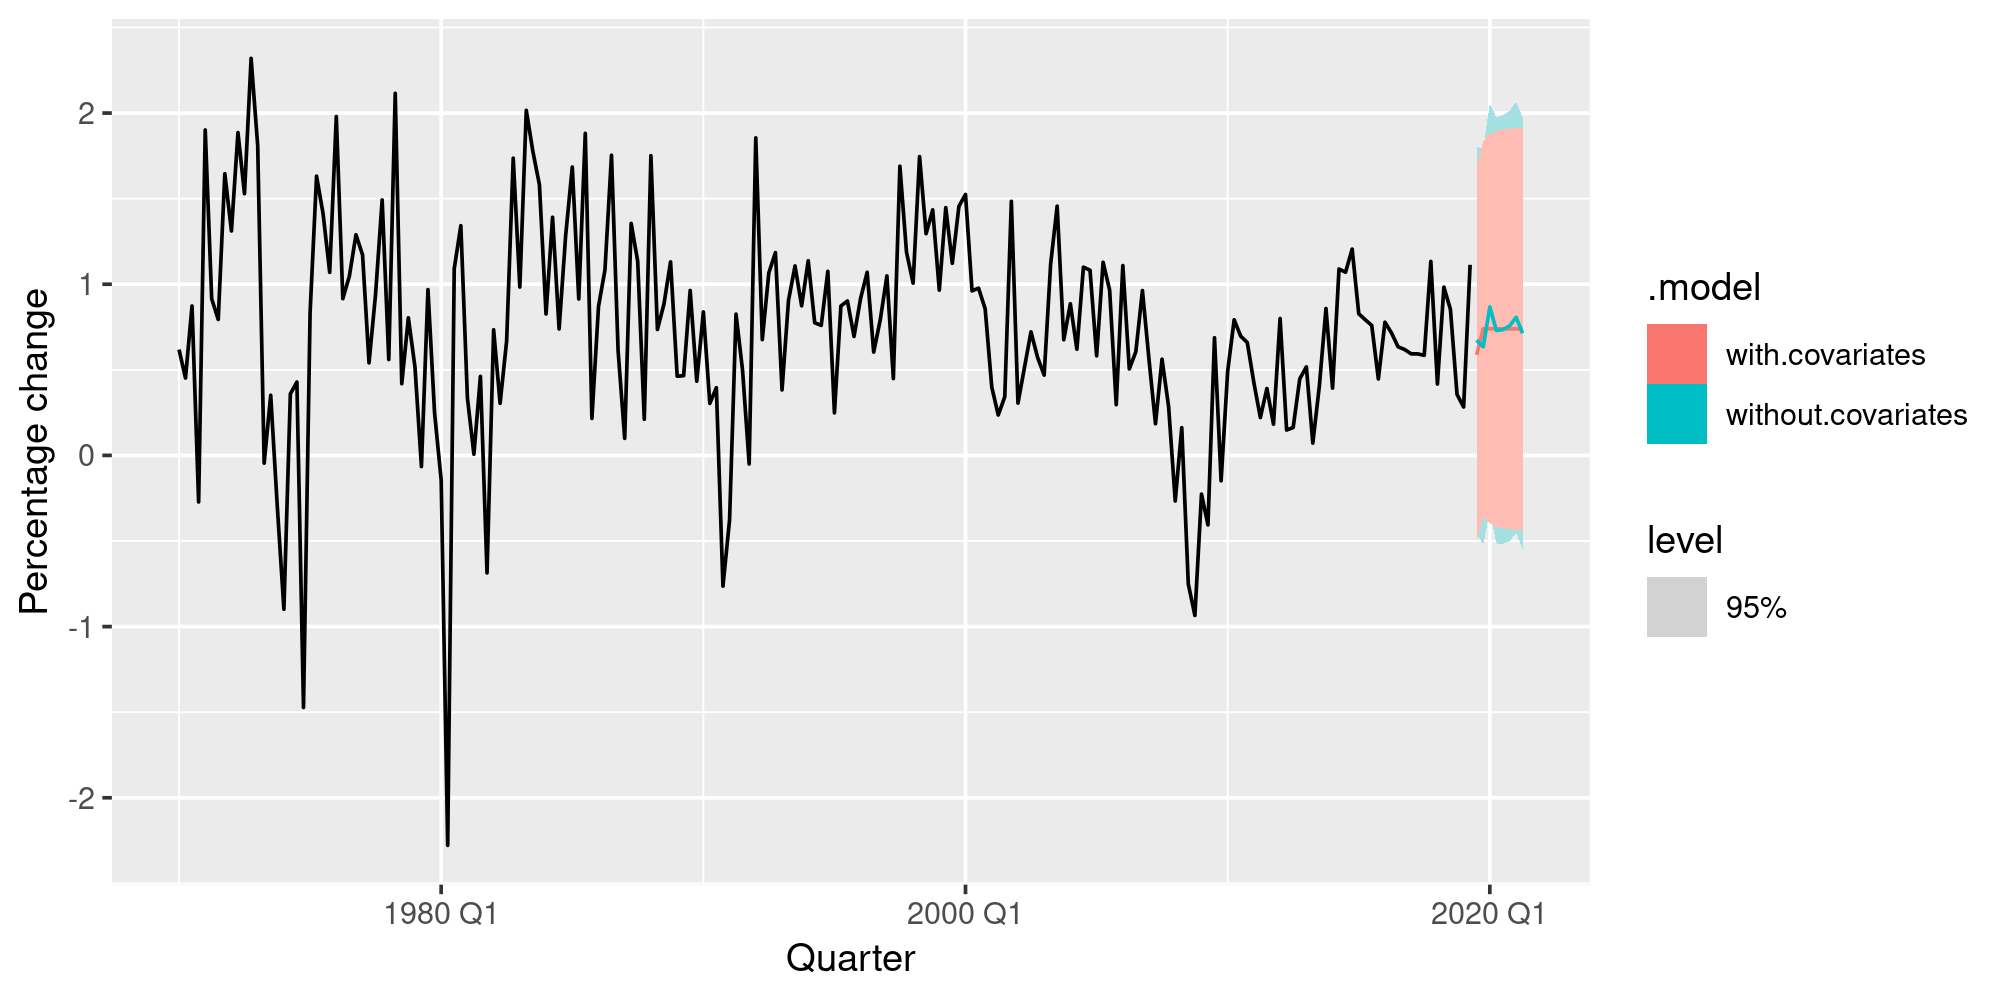

In [11]:
us_change |>
    model(with.covariates = ARIMA(Consumption ~ Income),
          without.covariates = ARIMA(Consumption)) |>
    forecast(new_data = us_change_future) |>
    autoplot(us_change, level=95) +
    labs(y = "Percentage change")

## Example: Forecasting electricity demand

Daily electricity demand can be modelled as a function of temperature. 

In [12]:
vic_elec_daily <- vic_elec |> filter(year(Time) == 2014) |>
  index_by(Date = date(Time)) |>
  summarise(Demand = sum(Demand) / 1e3,
    Temperature = max(Temperature),
    Holiday = any(Holiday)
  ) |>
  mutate(Day_Type = case_when(Holiday~"Holiday", wday(Date)%in%2:6~"Weekday",TRUE~"Weekend"))

vic_elec_daily

Date,Demand,Temperature,Holiday,Day_Type
<date>,<dbl>,<dbl>,<lgl>,<chr>
2014-01-01,175.1850,26,TRUE,Holiday
2014-01-02,188.3506,23,FALSE,Weekday
⋮,⋮,⋮,⋮,⋮
2014-12-30,186.1009,24.4,FALSE,Weekday
2014-12-31,186.1985,25.5,FALSE,Weekday


## Example: Forecasting electricity demand

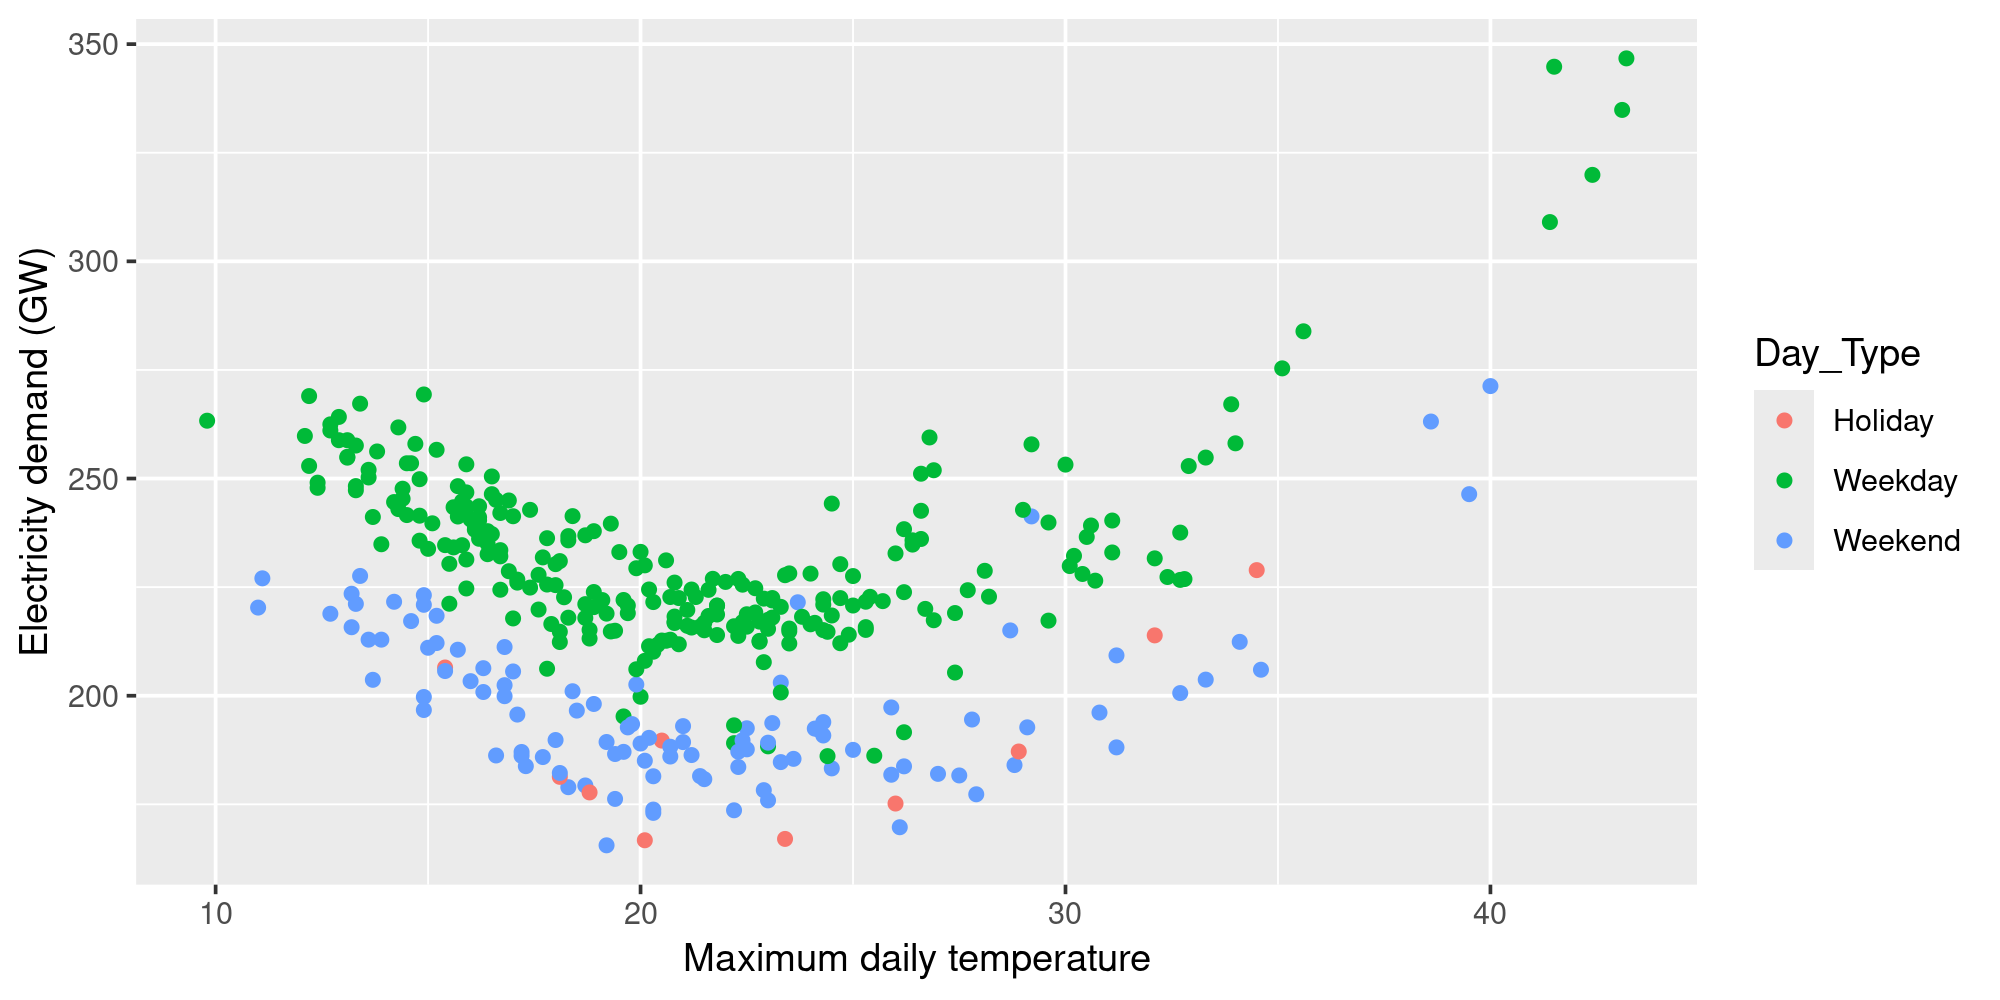

In [13]:
vic_elec_daily |>
  ggplot(aes(x = Temperature, y = Demand, colour = Day_Type)) +
  geom_point() +
  labs(y = "Electricity demand (GW)",
       x = "Maximum daily temperature")

## Example: Forecasting electricity demand

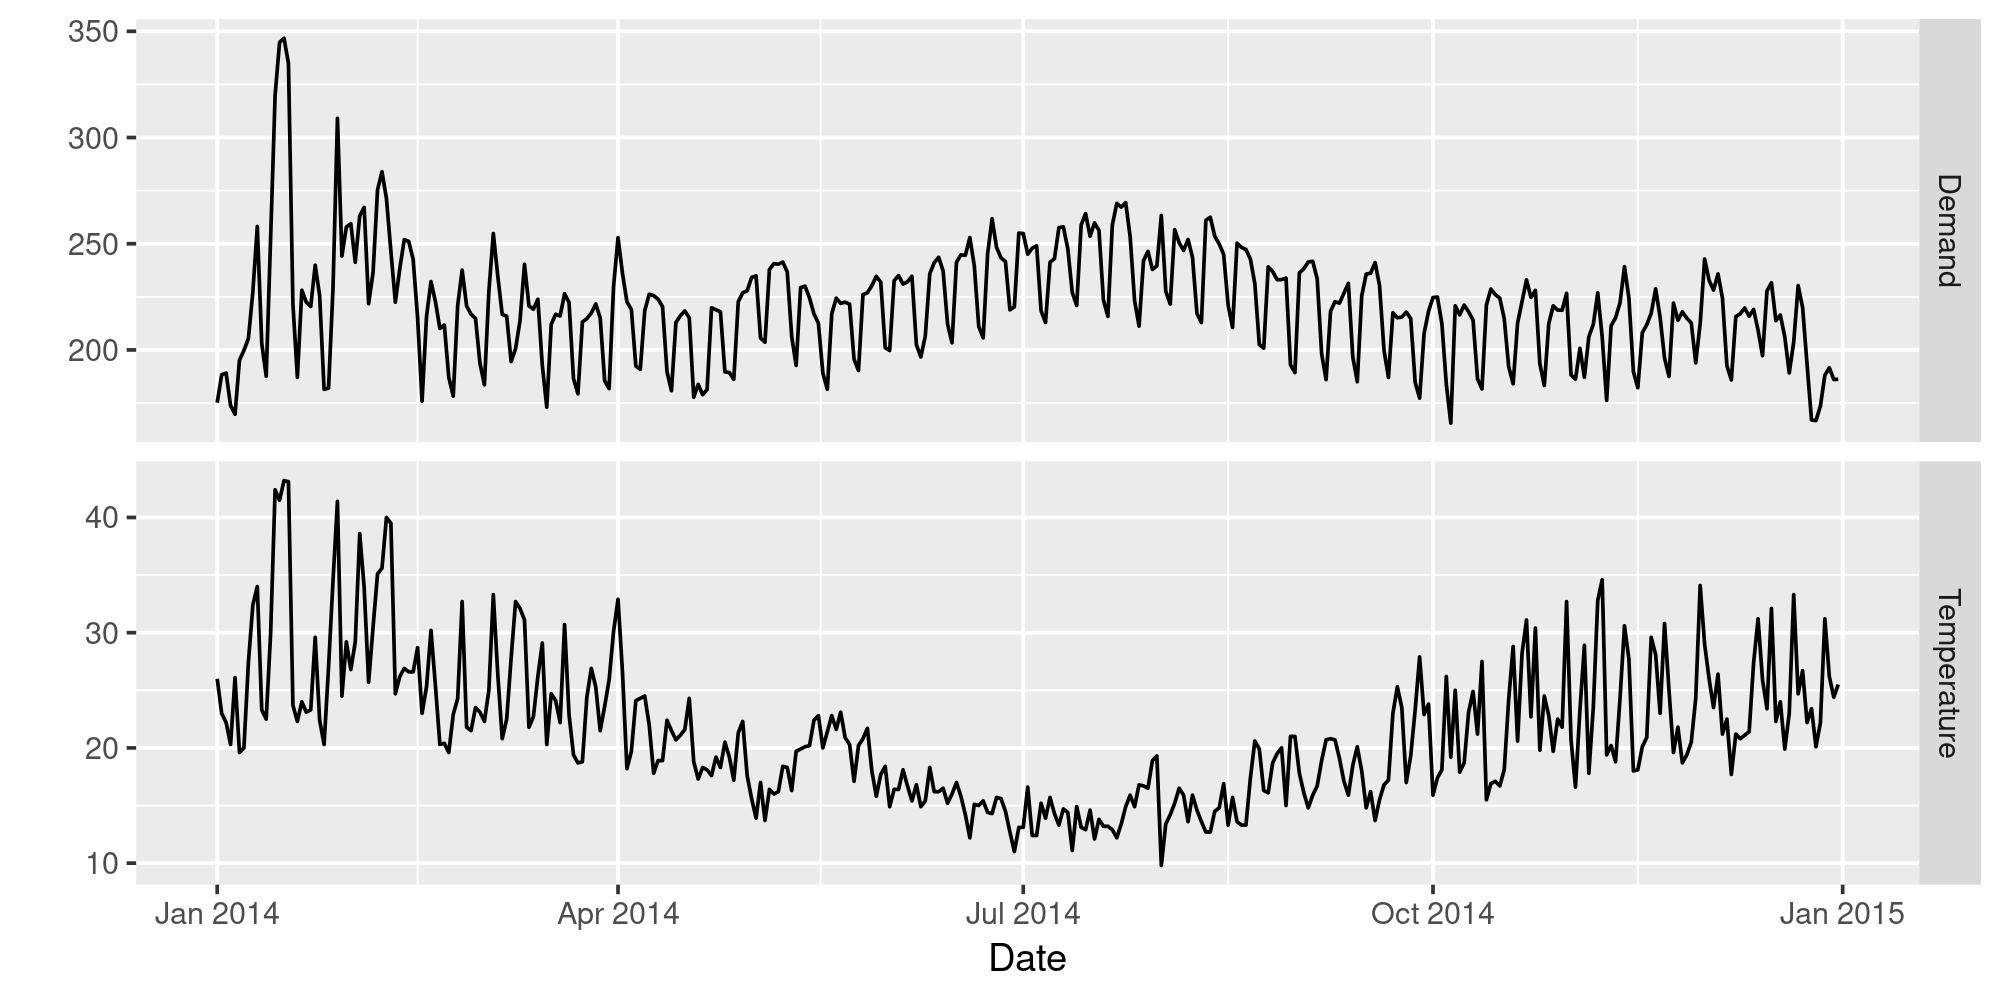

In [14]:
vic_elec_daily |>
  pivot_longer(c(Demand, Temperature)) |>
  ggplot(aes(x = Date, y = value)) +
  geom_line() +
  facet_grid(name ~ ., scales = "free_y") + ylab("")

## Example: Forecasting electricity demand

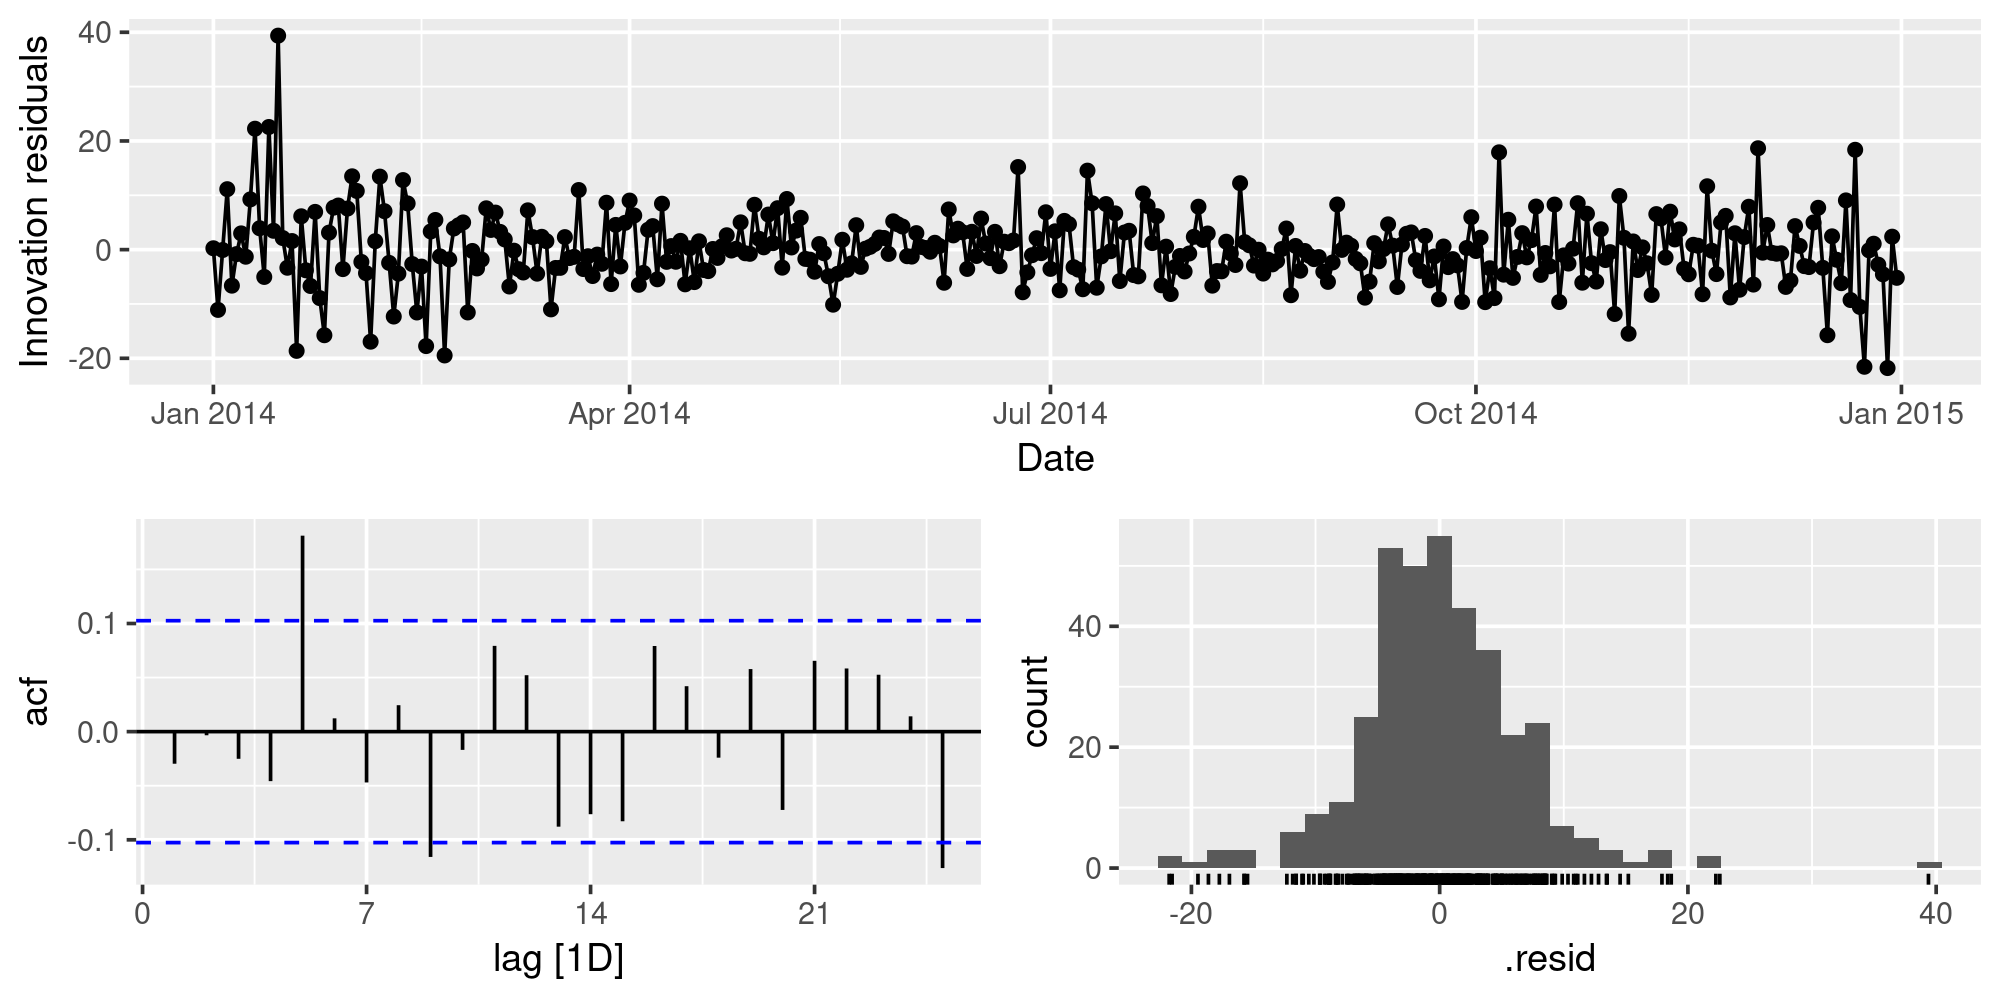

In [15]:
fit <- vic_elec_daily |>
  model(ARIMA(Demand ~ Temperature + I(Temperature^2) + (Day_Type == "Weekday")))
fit |> gg_tsresiduals()

## Example: Forecasting electricity demand

Using the estimated model we forecast 14 days ahead starting from Thursday 1 January 2015 (a non-work-day being a public holiday for New Years Day).

We will use scenario based forecasting where we set the temperature for the next 7 days to a constant 26 degrees and for the subsequent 7 days to 40 degrees (heat wave).

In [16]:
vic_elec_future <- new_data(vic_elec_daily, 14) |>
  mutate(
    Temperature = c(rep(26,7),rep(40,7)),
    Holiday = c(TRUE, rep(FALSE, 13)),
    Day_Type=case_when(Holiday~"Holiday", wday(Date)%in%2:6~"Weekday",TRUE~"Weekend")
  )
vic_elec_future

Date,Temperature,Holiday,Day_Type
<date>,<dbl>,<lgl>,<chr>
2015-01-01,26,TRUE,Holiday
2015-01-02,26,FALSE,Weekday
⋮,⋮,⋮,⋮
2015-01-13,40,FALSE,Weekday
2015-01-14,40,FALSE,Weekday


## Example: Forecasting electricity demand

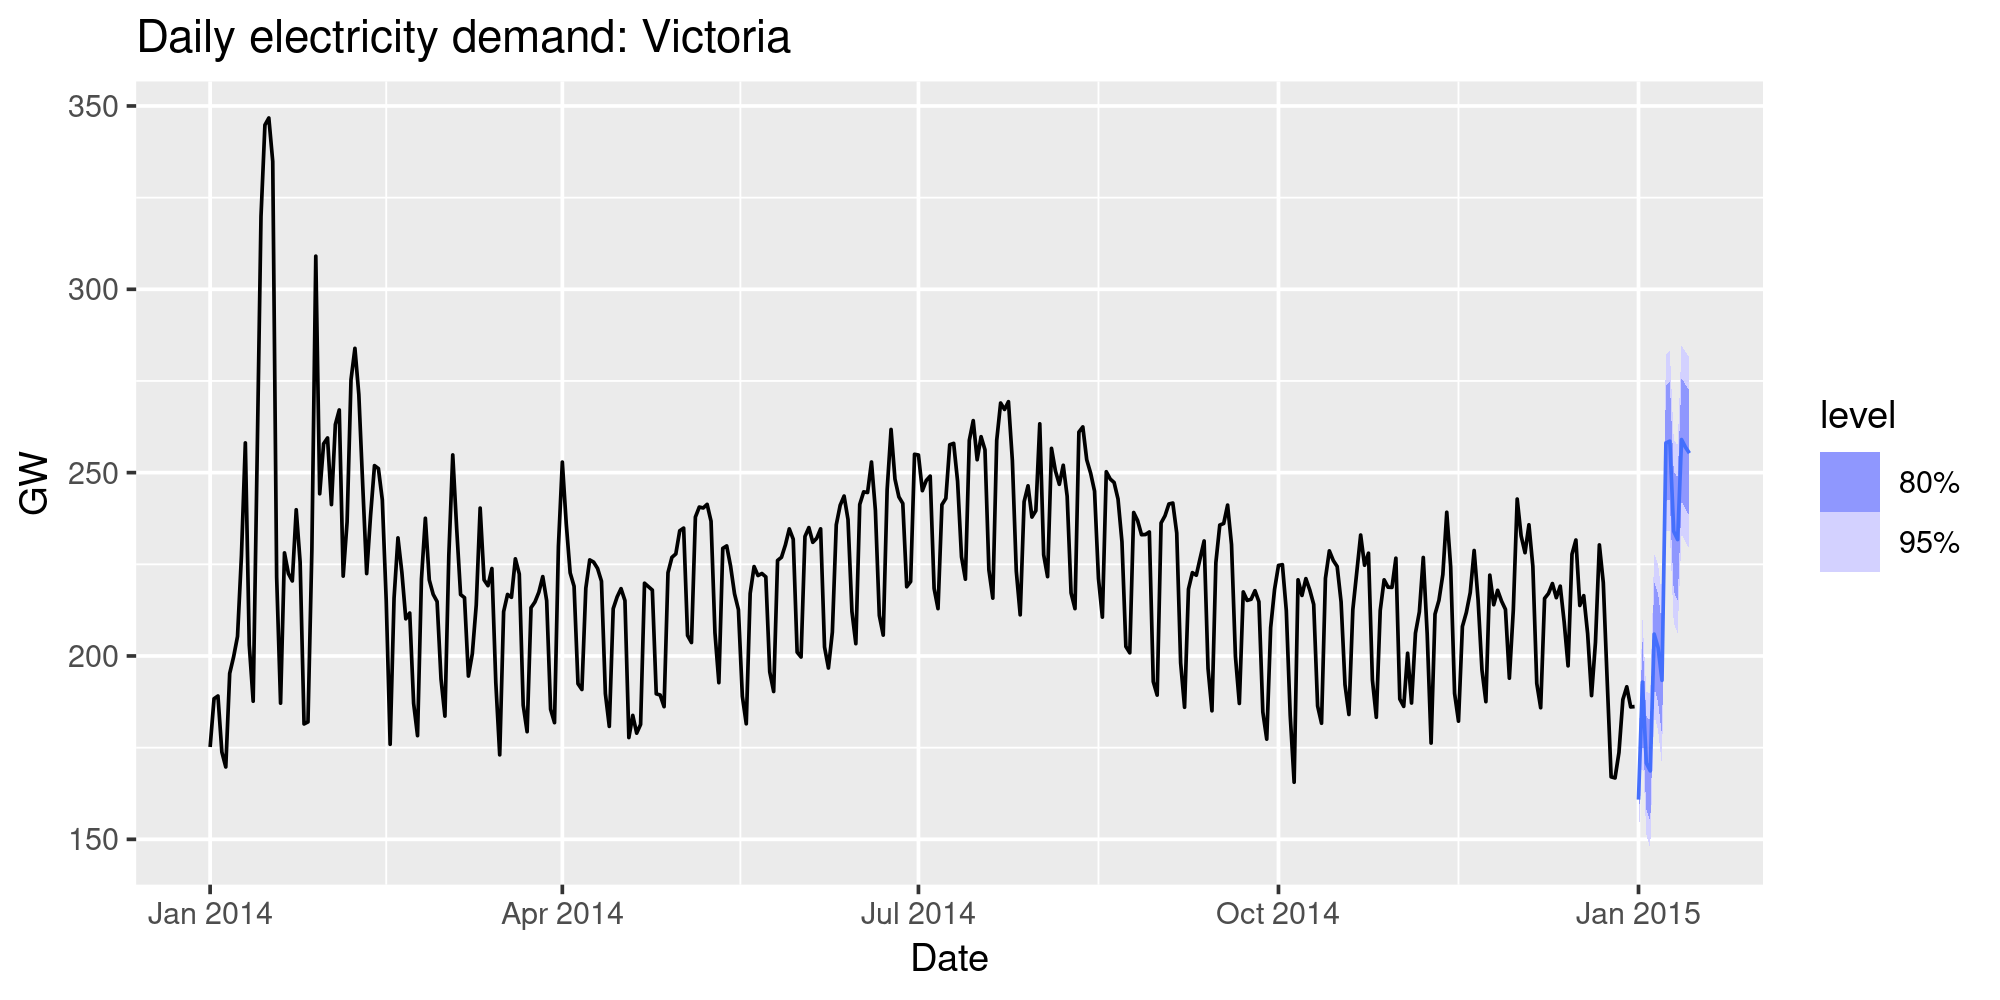

In [17]:
forecast(fit, vic_elec_future) |>
  autoplot(vic_elec_daily) +
  labs(title="Daily electricity demand: Victoria",y="GW")

## Example: Forecasting electricity demand

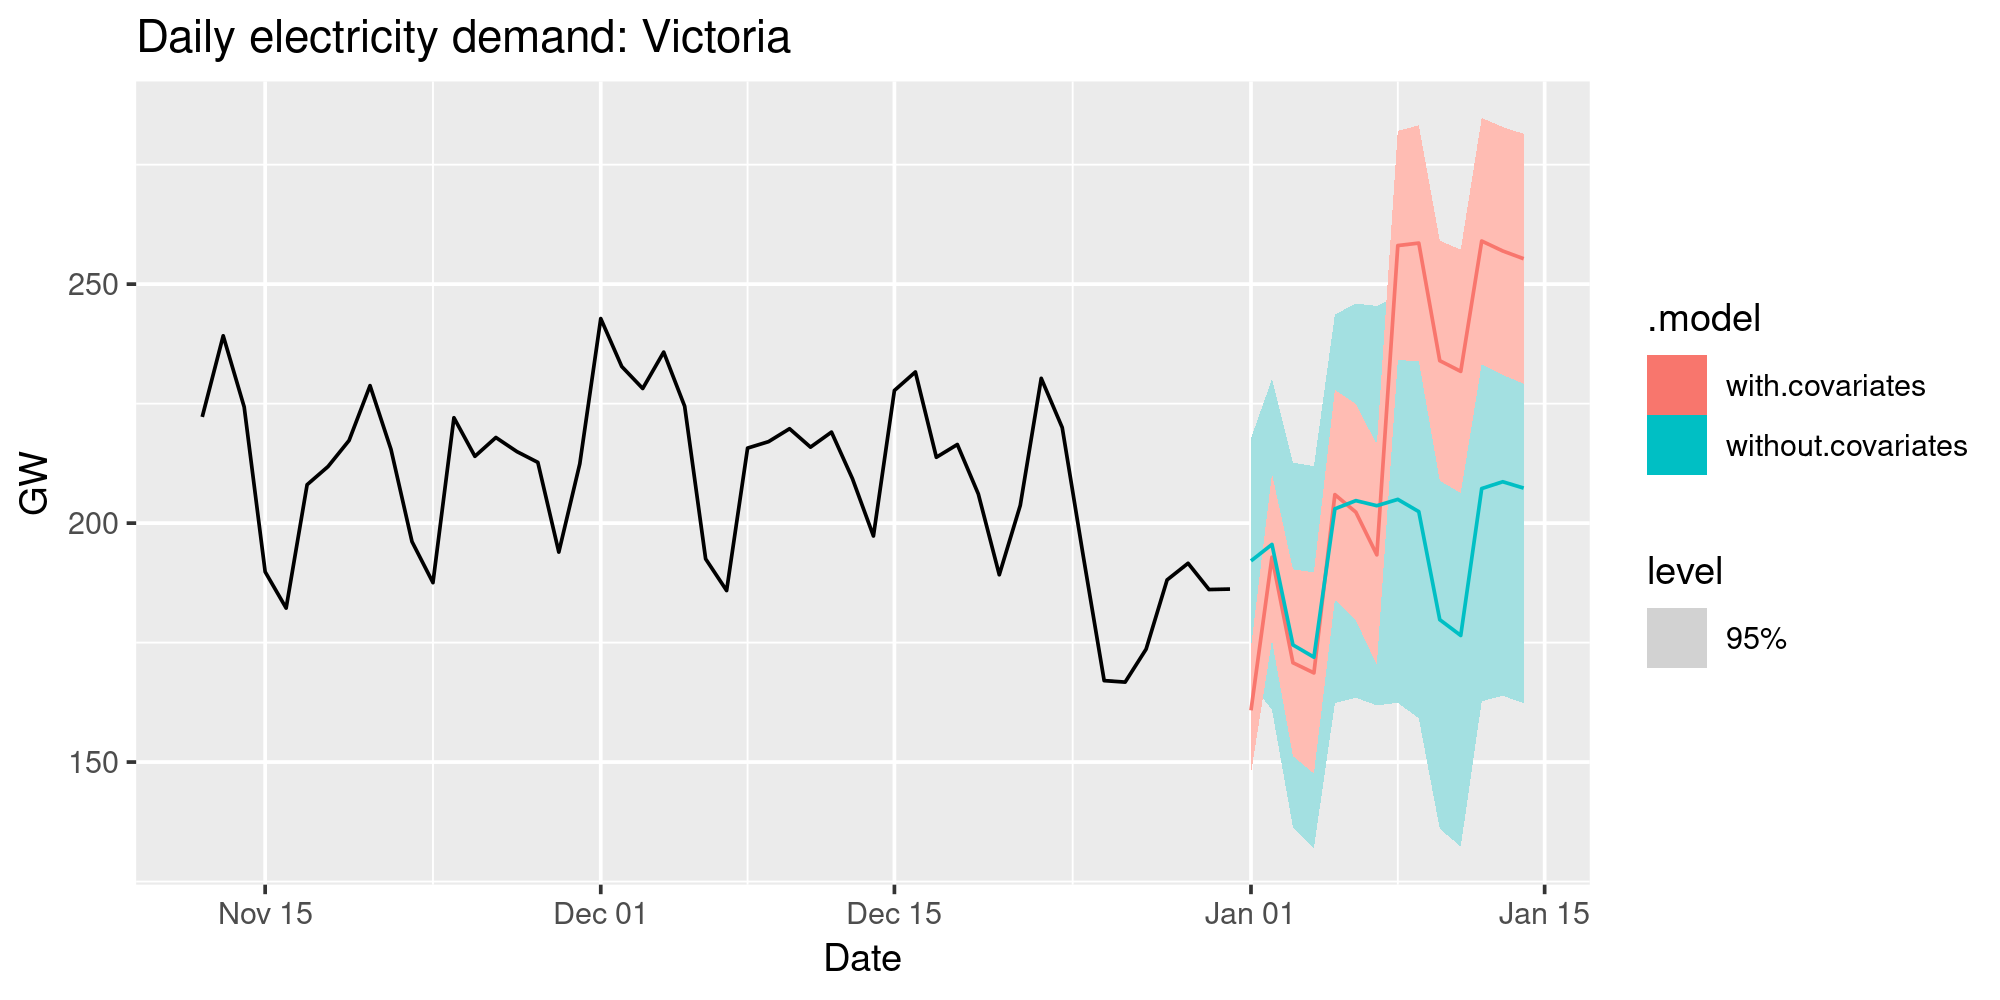

In [18]:
vic_elec_daily |>
    model(with.covariates = ARIMA(Demand ~ Temperature + I(Temperature^2) + (Day_Type == "Weekday")),
          without.covariates = ARIMA(Demand)) |>
    forecast(vic_elec_future) |>
    autoplot(tail(vic_elec_daily,50), level=95) +
    labs(title="Daily electricity demand: Victoria",y="GW")

## Stochastic and deterministic trends

There are two different ways of modelling a linear trend. 

A **deterministic trend** is obtained using the regression model 
$$
y_t = \beta_0 + \beta_1 t + \eta_t,
$$
where $\eta_t$  is an ARMA process.

A **stochastic trend** is obtained using the model 
$$y_t = \beta_0 + \beta_1 t + \eta_t,$$
where $\eta_t$ is an ARIMA process with $d=1$. 

In the latter case, we can difference both sides so that $y'_t=\beta_1+\eta'_t$, where $\eta'_t$ is an ARMA process. 
In other words, 
$$y_t = y_{t-1} + \beta_1 + \eta_t'.$$

Although these models appear quite similar (they only differ in the number of differences that need to be applied to $\eta_t$), their forecasting characteristics are quite different.

## Example: Air transport passengers Australia

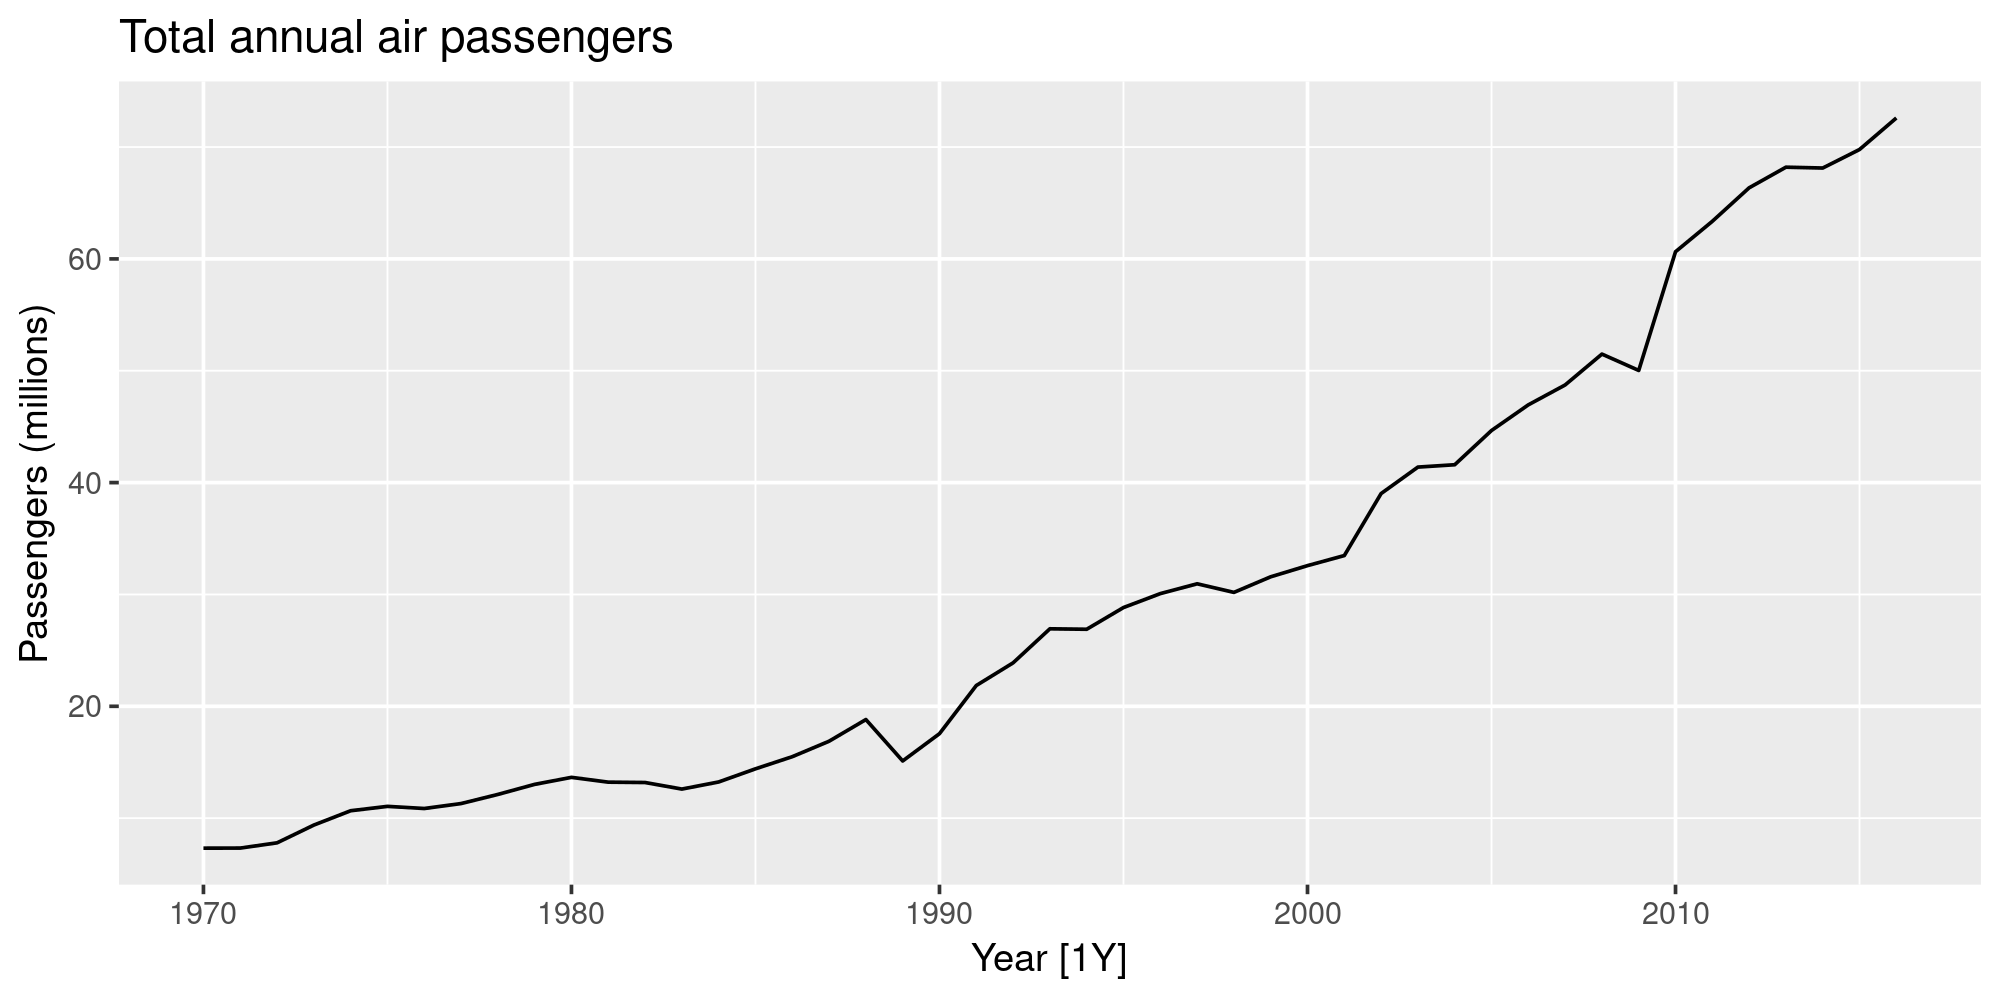

In [19]:
aus_airpassengers |>
  autoplot(Passengers) +
  labs(y = "Passengers (millions)", title = "Total annual air passengers")

## Example: Air transport passengers Australia

The deterministic trend model is obtained as follows:

In [20]:
fit_deterministic <- aus_airpassengers |>
  model(deterministic = ARIMA(Passengers ~ 1 + trend() +
                                pdq(d = 0)))
report(fit_deterministic)

Series: Passengers 
Model: LM w/ ARIMA(1,0,0) errors 

Coefficients:
         ar1  trend()  intercept
      0.9564   1.4151     0.9014
s.e.  0.0362   0.1972     7.0751

sigma^2 estimated as 4.343:  log likelihood=-100.88
AIC=209.77   AICc=210.72   BIC=217.17


This model can be written as 
\begin{align*}
  y_t &= 0.901 + 1.415 t + \eta_t \\
  \eta_t &= 0.956 \eta_{t-1}  + \varepsilon_t\\
  \varepsilon_t &\sim \text{N}(0,4.343).
\end{align*}
The estimated growth in visitor numbers is 1.42 million people per year.

## Example: Air transport passengers Australia

The stochastic trend model is obtained as follows:

In [22]:
fit_stochastic <- aus_airpassengers |>
  model(stochastic = ARIMA(Passengers ~ pdq(d = 1)))
report(fit_stochastic)

Series: Passengers 
Model: ARIMA(0,1,0) w/ drift 

Coefficients:
      constant
        1.4191
s.e.    0.3014

sigma^2 estimated as 4.271:  log likelihood=-98.16
AIC=200.31   AICc=200.59   BIC=203.97


This model can be written as $y_t - y_{t-1} = 1.419 + \varepsilon_t$, or 
\begin{align*}
  y_t &= y_0 + 1.419 t + \eta_t \\
  \eta_t &= \eta_{t-1} + \varepsilon_{t}\\
  \varepsilon_t &\sim \text{N}(0,4.271).
\end{align*}
In this case, the estimated growth in visitor numbers is also 1.42 million people per year. 

Although the growth estimates are similar, the prediction intervals are not.

## Example: Air transport passengers Australia

The stochastic trend model is obtained as follows:

Scale for fill_ramp is already present.
Adding another scale for fill_ramp, which will replace the existing scale.


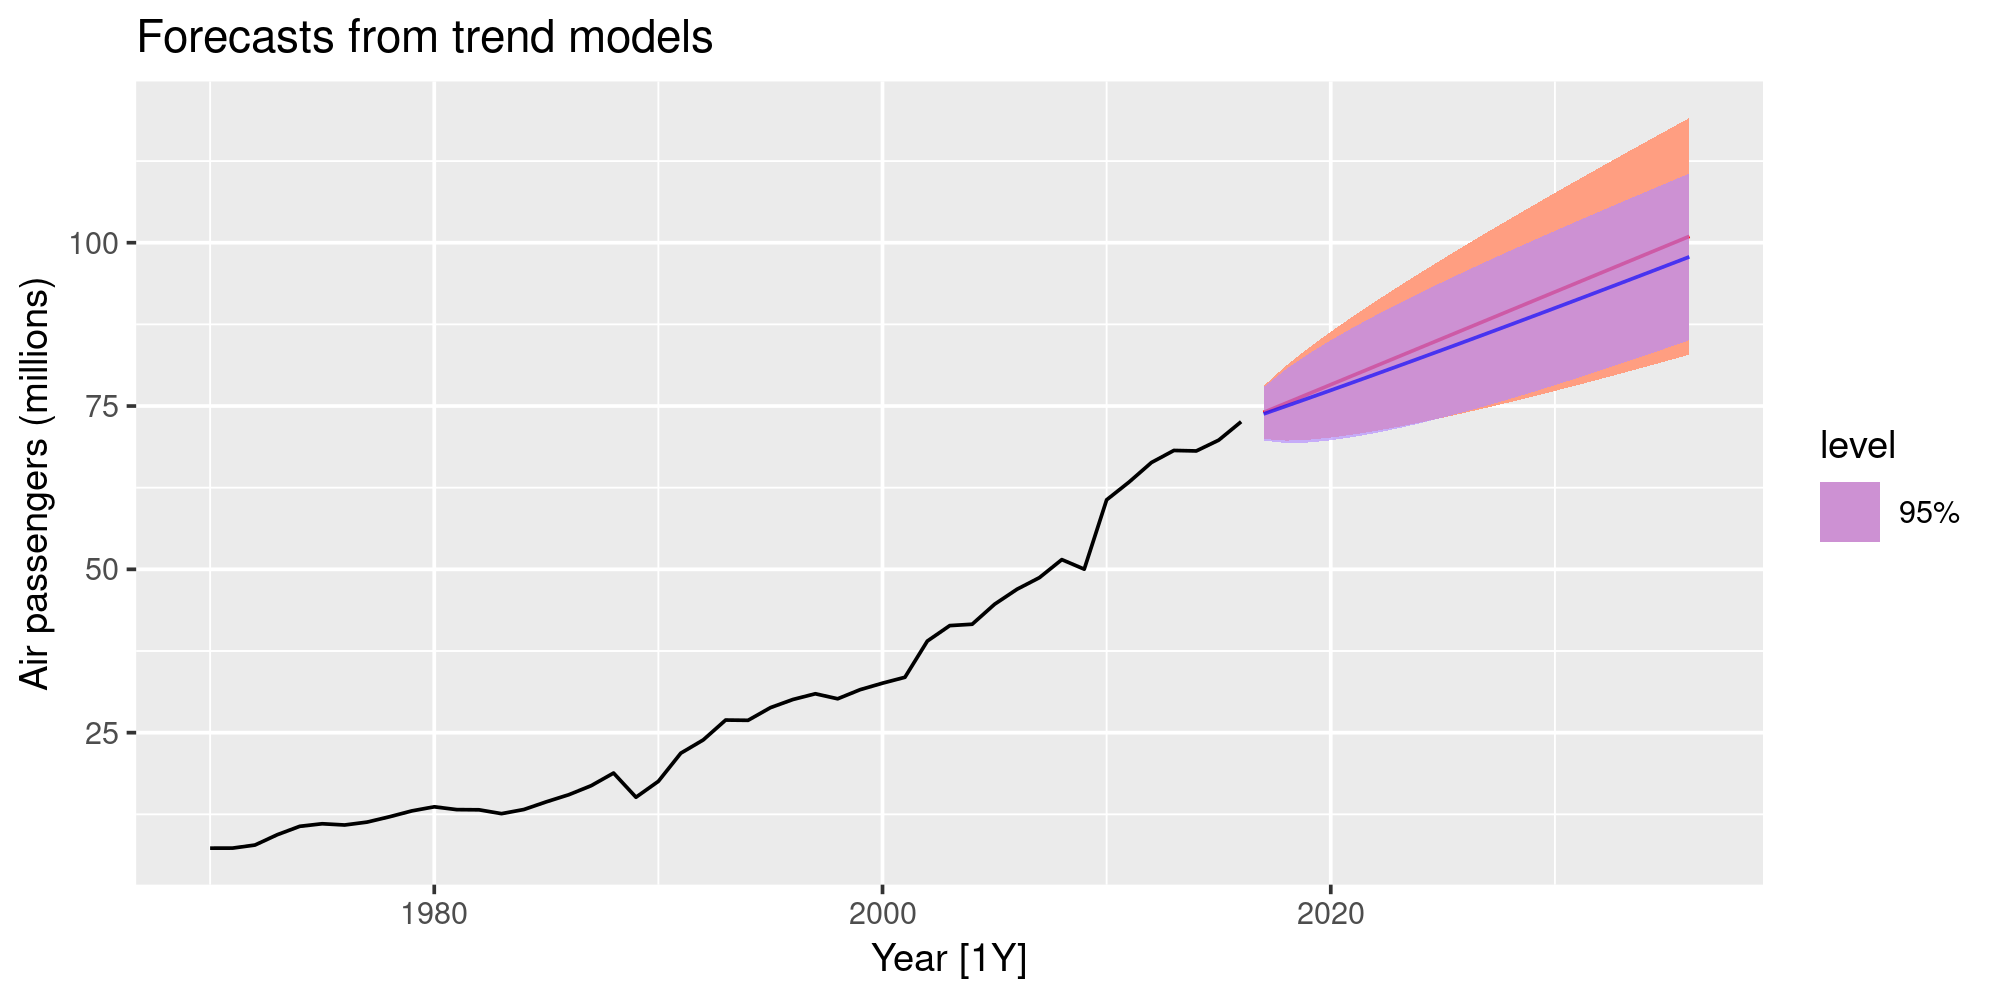

In [27]:
aus_airpassengers |>
    autoplot(Passengers) +
    autolayer(fit_stochastic |> forecast(h = 20),
              colour = "red", level = 95) +
    autolayer(fit_deterministic |> forecast(h = 20),
              colour = "blue", alpha = 0.65, level = 95) +
    labs(y = "Air passengers (millions)", title = "Forecasts from trend models")

## Stochastic and deterministic trends

There is an implicit assumption with deterministic trends that the slope of the trend is not going to change over time. On the other hand, stochastic trends can change, and the estimated growth is only assumed to be the average growth over the historical period, not necessarily the rate of growth that will be observed into the future. 

Consequently, it is safer to forecast with stochastic trends, especially for longer forecast horizons, as the prediction intervals allow for greater uncertainty in future growth.

## Lagged predictors

Sometimes, the impact of a predictor that is included in a regression model will not be simple and immediate. 

For example, an advertising campaign may impact sales for some time beyond the end of the campaign, and sales in one month will depend on the advertising expenditure in each of the past few months. 

In these situations, we need to allow for lagged effects of the predictor. Suppose that we have only one predictor in our model. Then a model which allows for lagged effects can be written as 
$$
y_t = \beta_0 + \gamma_0x_t + \gamma_1 x_{t-1} + \dots + \gamma_k x_{t-k} + \eta_t,
$$
where $\eta_t$ is an ARIMA process.

The value of $k$ can be selected using the AICc, along with the values of $p$ and $q$ for the ARIMA error.

## Example: TV advertising and insurance quotations

A US insurance company advertises on national television in an attempt to increase the number of insurance quotations provided (and consequently the number of new policies).

In [30]:
insurance

Month,Quotes,TVadverts
<mth>,<dbl>,<dbl>
2002 Jan,12.97065,7.212725
2002 Feb,15.38714,9.443570
⋮,⋮,⋮
2005 Mar,17.49186,10.45629
2005 Apr,14.49168,8.72860


## Example: TV advertising and insurance quotations

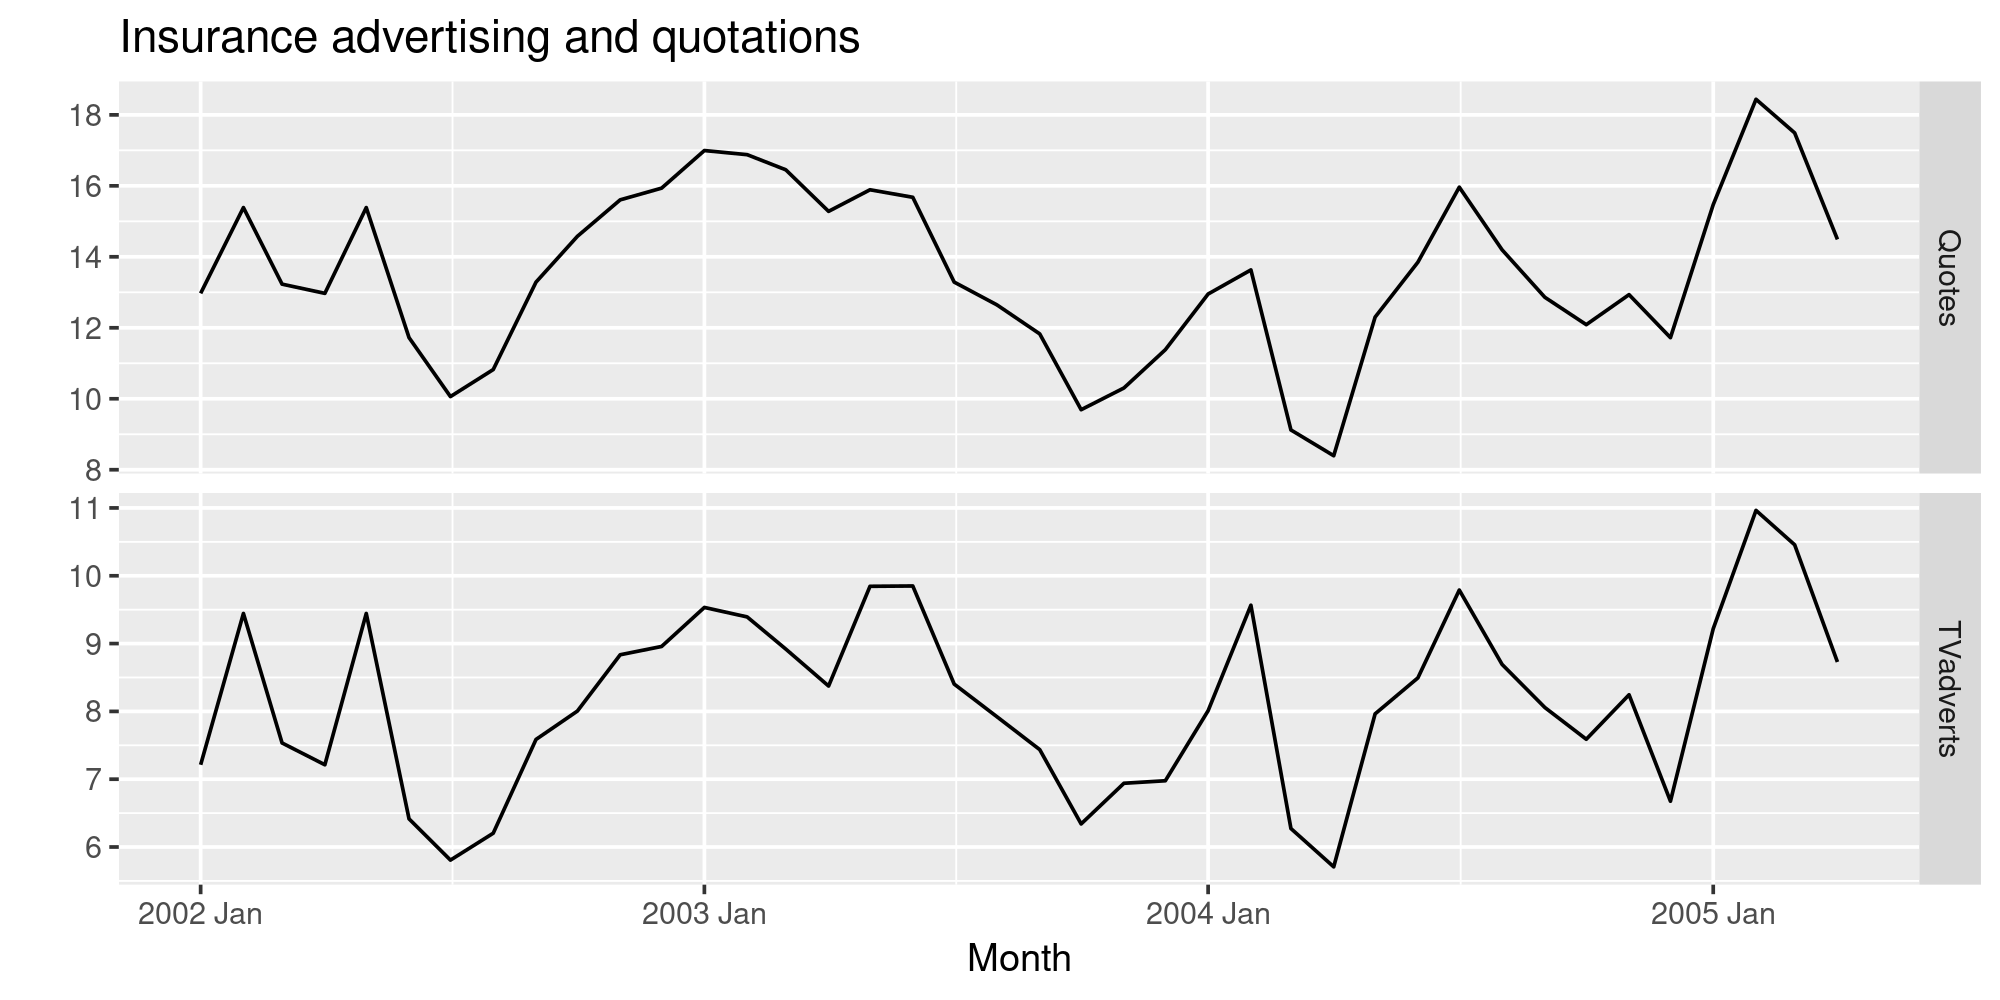

In [28]:
insurance |>
  pivot_longer(Quotes:TVadverts) |>
  ggplot(aes(x = Month, y = value)) +
  geom_line() +
  facet_grid(vars(name), scales = "free_y") +
  labs(y = "", title = "Insurance advertising and quotations")

## Example: TV advertising and insurance quotations

We will consider including advertising expenditure for up to four months; that is, the model may include advertising expenditure in the current month, and the three months before that.

When comparing models, it is important that they all use the same training set. In the following code, we exclude the first three months in order to make fair comparisons.

In [32]:
insurance_2 <- insurance |>
  mutate(Quotes = c(NA, NA, NA, Quotes[4:40])) 
insurance_2

Month,Quotes,TVadverts
<mth>,<dbl>,<dbl>
2002 Jan,NA,7.212725
2002 Feb,NA,9.443570
⋮,⋮,⋮
2005 Mar,17.49186,10.45629
2005 Apr,14.49168,8.72860


## Example: TV advertising and insurance quotations

In [57]:
fit <- insurance_2 |> model(
    lag0 = ARIMA(Quotes ~ pdq(d = 0) + TVadverts),
    lag1 = ARIMA(Quotes ~ pdq(d = 0) + TVadverts + lag(TVadverts)),
    lag2 = ARIMA(Quotes ~ pdq(d = 0) + TVadverts + lag(TVadverts) + lag(TVadverts, 2)),
    lag3 = ARIMA(Quotes ~ pdq(d = 0) + TVadverts + lag(TVadverts) + lag(TVadverts, 2) + lag(TVadverts, 3))
  )

In [70]:
fit |> select(lag0) |> report()

Series: Quotes 
Model: LM w/ ARIMA(2,0,0) errors 

Coefficients:
         ar1      ar2  TVadverts  intercept
      1.2321  -0.4642     1.2413     3.4262
s.e.  0.1636   0.1708     0.0751     0.6805

sigma^2 estimated as 0.265:  log likelihood=-28.28
AIC=66.56   AICc=68.33   BIC=75.01


## Example: TV advertising and insurance quotations

The chosen model has ARIMA(1,0,2) errors.

The model can be written as 
$$
y_t = 2.155 + 1.253 x_t + 0.146 x_{t-1} + \eta_t,
$$
where $y_t$ is the number of quotations provided in month $t$, $x_t$ is the advertising expenditure in month $t$, 
$$
\eta_t = 0.512 \eta_{t-1} +
                                     \varepsilon_t +
            0.917 \varepsilon_{t-1} +
            0.459 \varepsilon_{t-2},
$$
and $\varepsilon_t$ is white noise.

In [72]:
fit |> select(lag1) |> report()

Series: Quotes 
Model: LM w/ ARIMA(1,0,1) errors 

Coefficients:
         ar1     ma1  TVadverts  lag(TVadverts)
      0.6718  0.6713     1.3770          0.2745
s.e.  0.1324  0.1302     0.0374          0.0362

sigma^2 estimated as 0.2094:  log likelihood=-24.04
AIC=58.09   AICc=59.85   BIC=66.53


## Example: TV advertising and insurance quotations

We can calculate forecasts using this model if we assume future values for the advertising variable.

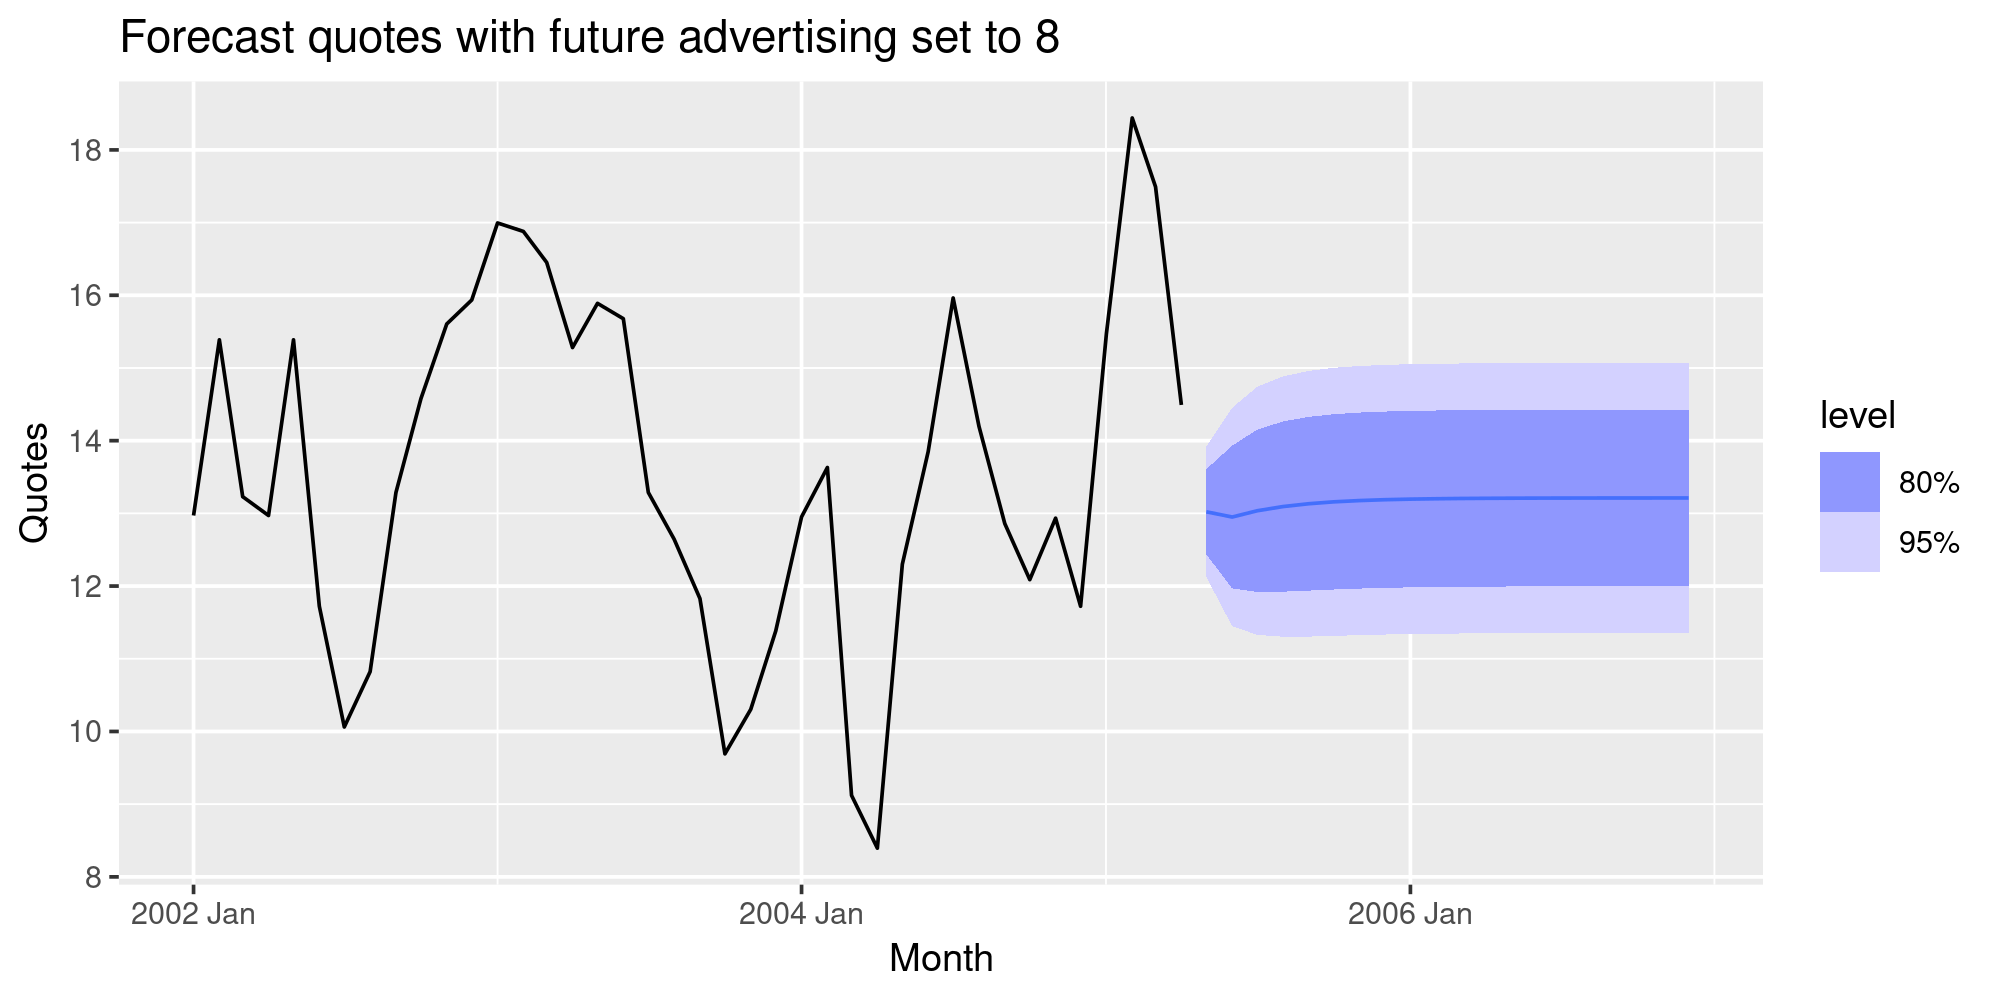

In [73]:
insurance_future <- new_data(insurance, 20) |> 
    mutate(TVadverts = 8)

fit |> select(lag1) |>
    forecast(insurance_future) |>
    autoplot(insurance) +
    labs(y = "Quotes", title = "Forecast quotes with future advertising set to 8")

## Next time

-  Forecasting hierarchical and grouped time series